In [23]:
from src.config import DEFAULT_DATA_FOLDER
from src.models.lstm.utils import determine_labels

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional
from typing import Union, Tuple, List

from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

import matplotlib.pyplot as plt

In [24]:
DATASET_PATH = f"{DEFAULT_DATA_FOLDER}/output/combined_posts_results.xlsx"
dataset = pd.read_excel(DATASET_PATH)

In [25]:
# Load pre-trained Word2Vec embeddings (example)
word2vec_path = f'{DEFAULT_DATA_FOLDER}/word-embedding/SO_vectors_200.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [26]:
# labels the columns
dataset['category'] = dataset.apply(determine_labels, axis=1)
dataset['clean_text'] = dataset['clean_text'].fillna('').astype(str)

label_encoder: LabelEncoder = LabelEncoder()
dataset['category'] = label_encoder.fit_transform(dataset['category'])
num_classes: int = len(label_encoder.classes_)

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['clean_text'], dataset['category'], test_size=0.2,
                                                    random_state=42)

In [28]:
# Tokenize and pad sequences
max_num_words: int = dataset['clean_text'].str.len().max()
print("Max number of words: ", max_num_words)
max_sequence_length: int = 250
tokenizer: Tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

Max number of words:  16317


In [29]:
X_train_padded: np.ndarray = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded: np.ndarray = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Convert labels to categorical
y_train_categorical: np.ndarray = to_categorical(y_train, num_classes=num_classes)
y_test_categorical: np.ndarray = to_categorical(y_test, num_classes=num_classes)

In [30]:
sequences = tokenizer.texts_to_sequences(dataset['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
labels_categorical: np.ndarray = to_categorical(dataset['category'], num_classes=num_classes)

In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies: List[float] = []

for train_index, test_index in skf.split(padded_sequences, dataset['category']):
    print(f'Training on fold {fold_no}...')

    # Split the data into training and testing sets
    X_train, X_test = padded_sequences[train_index], padded_sequences[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    # Build the LSTM model
    # embedding_dim: int = 100
    embedding_dim = word2vec_model.vector_size
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # word_index: your vocabulary index
    
    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    model: Sequential = Sequential()
    
    # Build the LSTM model with pre-trained embeddings
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))  # Set trainable=False to use pre-trained embeddings
    
    # model.add(Embedding(input_dim=max_num_words, output_dim=embedding_dim))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Define early stopping callback
    # early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    # 
    # # Train the model with early stopping
    # history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,
    #                     callbacks=[early_stopping], verbose=2)

    history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1,
                     verbose=2)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Accuracy for fold {fold_no}: {accuracy}')
    accuracies.append(accuracy)

    fold_no += 1

Training on fold 1...
Epoch 1/40
61/61 - 12s - 191ms/step - accuracy: 0.6170 - loss: 1.0046 - val_accuracy: 0.9860 - val_loss: 0.2188
Epoch 2/40
61/61 - 10s - 170ms/step - accuracy: 0.7011 - loss: 0.7653 - val_accuracy: 0.9721 - val_loss: 0.1545
Epoch 3/40
61/61 - 11s - 184ms/step - accuracy: 0.7400 - loss: 0.6714 - val_accuracy: 0.9442 - val_loss: 0.1861
Epoch 4/40
61/61 - 12s - 196ms/step - accuracy: 0.7639 - loss: 0.6156 - val_accuracy: 0.9767 - val_loss: 0.1255
Epoch 5/40
61/61 - 13s - 209ms/step - accuracy: 0.7878 - loss: 0.5545 - val_accuracy: 0.9721 - val_loss: 0.1206
Epoch 6/40
61/61 - 12s - 195ms/step - accuracy: 0.8142 - loss: 0.5013 - val_accuracy: 0.9302 - val_loss: 0.2103
Epoch 7/40
61/61 - 12s - 204ms/step - accuracy: 0.8334 - loss: 0.4480 - val_accuracy: 0.9674 - val_loss: 0.0961
Epoch 8/40
61/61 - 12s - 203ms/step - accuracy: 0.8412 - loss: 0.4270 - val_accuracy: 0.9628 - val_loss: 0.1373
Epoch 9/40
61/61 - 12s - 195ms/step - accuracy: 0.8516 - loss: 0.3928 - val_accura

In [32]:
# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f'Average Test Accuracy: {average_accuracy}')

Average Test Accuracy: 0.7474789917469025


In [33]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 250, 200)       │     4,967,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_34            │ (None, 250, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 200)            │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,691,814 (21.71 MB)

 Trainable params: 241,604 (943.77 KB)

 Non-trainable params: 4,967,000 (18.95 MB)

 Optimizer params: 483,210 (1.84 MB)

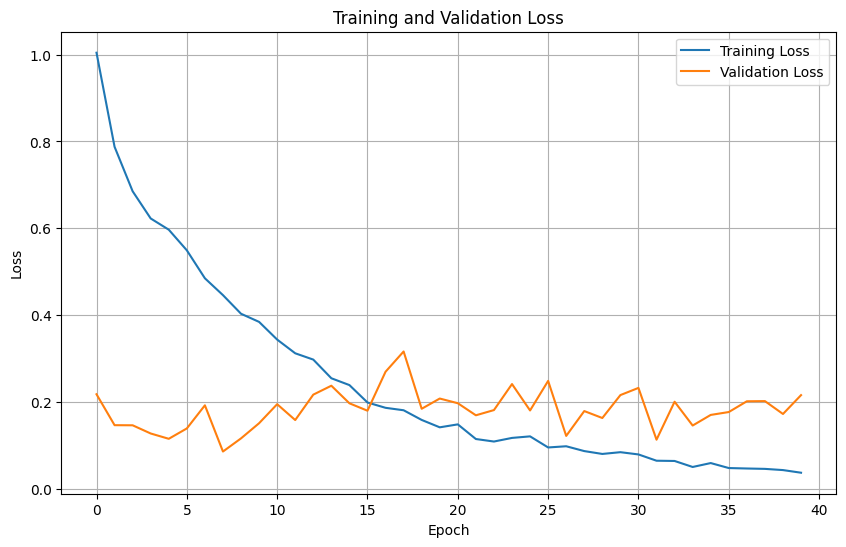

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
import os
# Ensure the model directory exists
model_dir = os.path.join(DEFAULT_DATA_FOLDER, "models")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model.save(f"{DEFAULT_DATA_FOLDER}/models/lstm.keras")

# optimizing paratermers


Training on fold 1 with params: embedding_dim=200, lstm_units=50, dropout_rate=0.2, batch_size=16
Epoch 1/20
121/121 - 7s - 59ms/step - accuracy: 0.6232 - loss: 1.0267 - val_accuracy: 0.9860 - val_loss: 0.2463
Epoch 2/20
121/121 - 8s - 68ms/step - accuracy: 0.6777 - loss: 0.8192 - val_accuracy: 0.9535 - val_loss: 0.1694
Epoch 3/20
121/121 - 8s - 67ms/step - accuracy: 0.7250 - loss: 0.7013 - val_accuracy: 0.9767 - val_loss: 0.1389
Epoch 4/20
121/121 - 8s - 67ms/step - accuracy: 0.7400 - loss: 0.6760 - val_accuracy: 0.9163 - val_loss: 0.2544
Epoch 5/20
121/121 - 8s - 67ms/step - accuracy: 0.7561 - loss: 0.6244 - val_accuracy: 0.9302 - val_loss: 0.2276
Epoch 6/20
121/121 - 8s - 65ms/step - accuracy: 0.7691 - loss: 0.5823 - val_accuracy: 0.9442 - val_loss: 0.1848
8/8 - 0s - 36ms/step
Test Accuracy for fold 1: 0.726890756302521
Test Precision for fold 1: 0.6653487201332146
Test Recall for fold 1: 0.726890756302521
Test F1 Score for fold 1: 0.689551560365186
Training on fold 2 with params: e

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 6s - 54ms/step - accuracy: 0.6134 - loss: 1.0092 - val_accuracy: 0.9814 - val_loss: 0.2444
Epoch 2/20
121/121 - 8s - 66ms/step - accuracy: 0.6803 - loss: 0.8030 - val_accuracy: 0.9256 - val_loss: 0.2461
Epoch 3/20
121/121 - 8s - 65ms/step - accuracy: 0.7281 - loss: 0.6935 - val_accuracy: 0.9209 - val_loss: 0.2469
Epoch 4/20
121/121 - 8s - 67ms/step - accuracy: 0.7597 - loss: 0.6289 - val_accuracy: 0.9628 - val_loss: 0.1488
Epoch 5/20
121/121 - 8s - 66ms/step - accuracy: 0.7774 - loss: 0.5786 - val_accuracy: 0.9721 - val_loss: 0.1161
Epoch 6/20
121/121 - 8s - 68ms/step - accuracy: 0.7815 - loss: 0.5561 - val_accuracy: 0.8930 - val_loss: 0.2488
Epoch 7/20
121/121 - 9s - 78ms/step - accuracy: 0.7981 - loss: 0.5225 - val_accuracy: 0.9163 - val_loss: 0.2217
Epoch 8/20
121/121 - 9s - 71ms/step - accuracy: 0.8225 - loss: 0.4797 - val_accuracy: 0.9581 - val_loss: 0.1475
8/8 - 0s - 38ms/step
Test Accuracy for fold 2: 0.7521008403361344
Test Precision for fold 2: 0.7002697390800399
Tes

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 7s - 54ms/step - accuracy: 0.6196 - loss: 0.9992 - val_accuracy: 0.9721 - val_loss: 0.3131
Epoch 2/20
121/121 - 8s - 67ms/step - accuracy: 0.6912 - loss: 0.7961 - val_accuracy: 0.9814 - val_loss: 0.1611
Epoch 3/20
121/121 - 8s - 66ms/step - accuracy: 0.7135 - loss: 0.7059 - val_accuracy: 0.9721 - val_loss: 0.1462
Epoch 4/20
121/121 - 8s - 66ms/step - accuracy: 0.7535 - loss: 0.6324 - val_accuracy: 0.9674 - val_loss: 0.1540
Epoch 5/20
121/121 - 8s - 66ms/step - accuracy: 0.7670 - loss: 0.6000 - val_accuracy: 0.9488 - val_loss: 0.1912
Epoch 6/20
121/121 - 8s - 66ms/step - accuracy: 0.8002 - loss: 0.5351 - val_accuracy: 0.9581 - val_loss: 0.1449
Epoch 7/20
121/121 - 8s - 66ms/step - accuracy: 0.8111 - loss: 0.5018 - val_accuracy: 0.9349 - val_loss: 0.1961
Epoch 8/20
121/121 - 8s - 66ms/step - accuracy: 0.8210 - loss: 0.4767 - val_accuracy: 0.9767 - val_loss: 0.1060
Epoch 9/20
121/121 - 8s - 66ms/step - accuracy: 0.8443 - loss: 0.4451 - val_accuracy: 0.9767 - val_loss: 0.1135
Epo

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 6s - 53ms/step - accuracy: 0.6269 - loss: 1.0164 - val_accuracy: 0.9814 - val_loss: 0.3249
Epoch 2/20
121/121 - 8s - 65ms/step - accuracy: 0.6741 - loss: 0.8216 - val_accuracy: 0.9581 - val_loss: 0.1996
Epoch 3/20
121/121 - 8s - 67ms/step - accuracy: 0.7193 - loss: 0.7193 - val_accuracy: 0.9581 - val_loss: 0.1866
Epoch 4/20
121/121 - 9s - 77ms/step - accuracy: 0.7483 - loss: 0.6665 - val_accuracy: 0.9535 - val_loss: 0.1569
Epoch 5/20
121/121 - 11s - 88ms/step - accuracy: 0.7602 - loss: 0.6137 - val_accuracy: 0.9860 - val_loss: 0.1040
Epoch 6/20
121/121 - 11s - 94ms/step - accuracy: 0.7789 - loss: 0.5805 - val_accuracy: 0.9535 - val_loss: 0.1471
Epoch 7/20
121/121 - 11s - 89ms/step - accuracy: 0.7992 - loss: 0.5421 - val_accuracy: 0.9628 - val_loss: 0.1333
Epoch 8/20
121/121 - 11s - 91ms/step - accuracy: 0.8064 - loss: 0.5082 - val_accuracy: 0.9349 - val_loss: 0.1616
8/8 - 0s - 56ms/step
Test Accuracy for fold 5: 0.7689075630252101
Test Precision for fold 5: 0.7178469549436415

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 10s - 80ms/step - accuracy: 0.6253 - loss: 0.9993 - val_accuracy: 0.9953 - val_loss: 0.2668
Epoch 2/20
121/121 - 10s - 80ms/step - accuracy: 0.6731 - loss: 0.8101 - val_accuracy: 0.8837 - val_loss: 0.3166
Epoch 3/20
121/121 - 9s - 78ms/step - accuracy: 0.7193 - loss: 0.7004 - val_accuracy: 0.9070 - val_loss: 0.2721
Epoch 4/20
121/121 - 9s - 75ms/step - accuracy: 0.7473 - loss: 0.6693 - val_accuracy: 0.9395 - val_loss: 0.1916
Epoch 5/20
121/121 - 9s - 73ms/step - accuracy: 0.7514 - loss: 0.6358 - val_accuracy: 0.8977 - val_loss: 0.2054
Epoch 6/20
121/121 - 9s - 73ms/step - accuracy: 0.7903 - loss: 0.5708 - val_accuracy: 0.9628 - val_loss: 0.1208
Epoch 7/20
121/121 - 9s - 71ms/step - accuracy: 0.8075 - loss: 0.5355 - val_accuracy: 0.8837 - val_loss: 0.2760
Epoch 8/20
121/121 - 9s - 71ms/step - accuracy: 0.8163 - loss: 0.5002 - val_accuracy: 0.9209 - val_loss: 0.2162
Epoch 9/20
121/121 - 9s - 71ms/step - accuracy: 0.8277 - loss: 0.4606 - val_accuracy: 0.9349 - val_loss: 0.1668
8

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 66ms/step - accuracy: 0.6092 - loss: 1.0465 - val_accuracy: 0.9814 - val_loss: 0.2476
Epoch 2/20
121/121 - 8s - 67ms/step - accuracy: 0.6684 - loss: 0.8507 - val_accuracy: 0.9907 - val_loss: 0.1233
Epoch 3/20
121/121 - 8s - 67ms/step - accuracy: 0.7130 - loss: 0.7362 - val_accuracy: 0.9395 - val_loss: 0.2342
Epoch 4/20
121/121 - 8s - 67ms/step - accuracy: 0.7343 - loss: 0.6780 - val_accuracy: 0.9674 - val_loss: 0.1333
Epoch 5/20
121/121 - 8s - 67ms/step - accuracy: 0.7701 - loss: 0.6180 - val_accuracy: 0.9814 - val_loss: 0.0890
Epoch 6/20
121/121 - 8s - 67ms/step - accuracy: 0.7794 - loss: 0.5875 - val_accuracy: 0.9535 - val_loss: 0.1362
Epoch 7/20
121/121 - 8s - 67ms/step - accuracy: 0.7857 - loss: 0.5582 - val_accuracy: 0.9721 - val_loss: 0.1052
Epoch 8/20
121/121 - 8s - 67ms/step - accuracy: 0.8049 - loss: 0.5143 - val_accuracy: 0.9349 - val_loss: 0.1816
8/8 - 0s - 42ms/step
Test Accuracy for fold 8: 0.7521008403361344
Test Precision for fold 8: 0.6948948741547718
Tes

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 95ms/step - accuracy: 0.5911 - loss: 1.0767 - val_accuracy: 0.9860 - val_loss: 0.3052
Epoch 2/20
61/61 - 5s - 76ms/step - accuracy: 0.6539 - loss: 0.8984 - val_accuracy: 0.9814 - val_loss: 0.2213
Epoch 3/20
61/61 - 6s - 90ms/step - accuracy: 0.6923 - loss: 0.7877 - val_accuracy: 0.9488 - val_loss: 0.2129
Epoch 4/20
61/61 - 5s - 89ms/step - accuracy: 0.7343 - loss: 0.6890 - val_accuracy: 0.9767 - val_loss: 0.1242
Epoch 5/20
61/61 - 5s - 90ms/step - accuracy: 0.7436 - loss: 0.6478 - val_accuracy: 0.9674 - val_loss: 0.1384
Epoch 6/20
61/61 - 5s - 85ms/step - accuracy: 0.7649 - loss: 0.6160 - val_accuracy: 0.9163 - val_loss: 0.2506
Epoch 7/20
61/61 - 5s - 89ms/step - accuracy: 0.7831 - loss: 0.5710 - val_accuracy: 0.9395 - val_loss: 0.2190
8/8 - 0s - 45ms/step
Test Accuracy for fold 1: 0.7521008403361344
Test Precision for fold 1: 0.6902554772353138
Test Recall for fold 1: 0.7521008403361344
Test F1 Score for fold 1: 0.7092196211173056
Training on fold 2 with params: embedding

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 91ms/step - accuracy: 0.6113 - loss: 1.0509 - val_accuracy: 1.0000 - val_loss: 0.2657
Epoch 2/20
61/61 - 5s - 74ms/step - accuracy: 0.6653 - loss: 0.8710 - val_accuracy: 0.9488 - val_loss: 0.2920
Epoch 3/20
61/61 - 5s - 86ms/step - accuracy: 0.7032 - loss: 0.7535 - val_accuracy: 0.9535 - val_loss: 0.1637
Epoch 4/20
61/61 - 5s - 81ms/step - accuracy: 0.7229 - loss: 0.6967 - val_accuracy: 0.9674 - val_loss: 0.1248
Epoch 5/20
61/61 - 5s - 81ms/step - accuracy: 0.7478 - loss: 0.6530 - val_accuracy: 0.9302 - val_loss: 0.1879
Epoch 6/20
61/61 - 5s - 82ms/step - accuracy: 0.7582 - loss: 0.6172 - val_accuracy: 0.9116 - val_loss: 0.2229
Epoch 7/20
61/61 - 5s - 89ms/step - accuracy: 0.7800 - loss: 0.5727 - val_accuracy: 0.9256 - val_loss: 0.2040
8/8 - 0s - 45ms/step
Test Accuracy for fold 2: 0.7563025210084033
Test Precision for fold 2: 0.7088509316770186
Test Recall for fold 2: 0.7563025210084033
Test F1 Score for fold 2: 0.719170526854988
Training on fold 3 with params: embedding_

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 94ms/step - accuracy: 0.5937 - loss: 1.0802 - val_accuracy: 1.0000 - val_loss: 0.2992
Epoch 2/20
61/61 - 4s - 69ms/step - accuracy: 0.6601 - loss: 0.8861 - val_accuracy: 0.9907 - val_loss: 0.1965
Epoch 3/20
61/61 - 5s - 77ms/step - accuracy: 0.7011 - loss: 0.7744 - val_accuracy: 0.9488 - val_loss: 0.2112
Epoch 4/20
61/61 - 5s - 76ms/step - accuracy: 0.7156 - loss: 0.7099 - val_accuracy: 0.9395 - val_loss: 0.2443
Epoch 5/20
61/61 - 5s - 76ms/step - accuracy: 0.7540 - loss: 0.6582 - val_accuracy: 0.9209 - val_loss: 0.2245
8/8 - 0s - 44ms/step
Test Accuracy for fold 3: 0.6890756302521008
Test Precision for fold 3: 0.6134277240307888
Test Recall for fold 3: 0.6890756302521008
Test F1 Score for fold 3: 0.6079682612818844
Training on fold 4 with params: embedding_dim=200, lstm_units=50, dropout_rate=0.2, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 86ms/step - accuracy: 0.6222 - loss: 1.0274 - val_accuracy: 0.9767 - val_loss: 0.3650
Epoch 2/20
61/61 - 4s - 69ms/step - accuracy: 0.6601 - loss: 0.8528 - val_accuracy: 0.9581 - val_loss: 0.2255
Epoch 3/20
61/61 - 5s - 76ms/step - accuracy: 0.7042 - loss: 0.7542 - val_accuracy: 0.9581 - val_loss: 0.1445
Epoch 4/20
61/61 - 5s - 75ms/step - accuracy: 0.7198 - loss: 0.7046 - val_accuracy: 0.9674 - val_loss: 0.1440
Epoch 5/20
61/61 - 5s - 79ms/step - accuracy: 0.7442 - loss: 0.6484 - val_accuracy: 0.9488 - val_loss: 0.1831
Epoch 6/20
61/61 - 5s - 79ms/step - accuracy: 0.7545 - loss: 0.6156 - val_accuracy: 0.9535 - val_loss: 0.1350
Epoch 7/20
61/61 - 5s - 76ms/step - accuracy: 0.7649 - loss: 0.6036 - val_accuracy: 0.9488 - val_loss: 0.1461
Epoch 8/20
61/61 - 5s - 76ms/step - accuracy: 0.7950 - loss: 0.5392 - val_accuracy: 0.9535 - val_loss: 0.1562
Epoch 9/20
61/61 - 5s - 77ms/step - accuracy: 0.8116 - loss: 0.5038 - val_accuracy: 0.9442 - val_loss: 0.1468
8/8 - 0s - 44ms/step


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 87ms/step - accuracy: 0.6056 - loss: 1.0545 - val_accuracy: 0.9907 - val_loss: 0.2562
Epoch 2/20
61/61 - 4s - 68ms/step - accuracy: 0.6549 - loss: 0.8801 - val_accuracy: 0.9860 - val_loss: 0.1731
Epoch 3/20
61/61 - 5s - 75ms/step - accuracy: 0.6897 - loss: 0.7898 - val_accuracy: 0.9814 - val_loss: 0.1277
Epoch 4/20
61/61 - 5s - 74ms/step - accuracy: 0.7099 - loss: 0.7232 - val_accuracy: 0.9907 - val_loss: 0.1170
Epoch 5/20
61/61 - 5s - 75ms/step - accuracy: 0.7483 - loss: 0.6627 - val_accuracy: 0.9535 - val_loss: 0.1777
Epoch 6/20
61/61 - 5s - 74ms/step - accuracy: 0.7483 - loss: 0.6310 - val_accuracy: 0.9628 - val_loss: 0.1587
Epoch 7/20
61/61 - 5s - 75ms/step - accuracy: 0.7680 - loss: 0.5986 - val_accuracy: 0.9628 - val_loss: 0.1396
8/8 - 0s - 44ms/step
Test Accuracy for fold 5: 0.7563025210084033
Test Precision for fold 5: 0.6761581555699203
Test Recall for fold 5: 0.7563025210084033
Test F1 Score for fold 5: 0.6924664937517137
Training on fold 6 with params: embedding

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 87ms/step - accuracy: 0.5854 - loss: 1.0639 - val_accuracy: 0.9907 - val_loss: 0.2314
Epoch 2/20
61/61 - 4s - 69ms/step - accuracy: 0.6570 - loss: 0.9051 - val_accuracy: 0.9674 - val_loss: 0.2272
Epoch 3/20
61/61 - 5s - 79ms/step - accuracy: 0.6746 - loss: 0.8049 - val_accuracy: 0.9535 - val_loss: 0.2005
Epoch 4/20
61/61 - 5s - 79ms/step - accuracy: 0.7213 - loss: 0.7178 - val_accuracy: 0.9721 - val_loss: 0.1490
Epoch 5/20
61/61 - 5s - 80ms/step - accuracy: 0.7379 - loss: 0.6668 - val_accuracy: 0.9209 - val_loss: 0.1821
Epoch 6/20
61/61 - 5s - 81ms/step - accuracy: 0.7711 - loss: 0.6178 - val_accuracy: 0.9302 - val_loss: 0.1866
Epoch 7/20
61/61 - 5s - 81ms/step - accuracy: 0.7789 - loss: 0.5728 - val_accuracy: 0.9256 - val_loss: 0.1753
8/8 - 0s - 45ms/step
Test Accuracy for fold 6: 0.7226890756302521
Test Precision for fold 6: 0.636042606630842
Test Recall for fold 6: 0.7226890756302521
Test F1 Score for fold 6: 0.6678982368513637
Training on fold 7 with params: embedding_

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 101ms/step - accuracy: 0.6129 - loss: 1.0419 - val_accuracy: 0.9814 - val_loss: 0.3295
Epoch 2/20
61/61 - 5s - 77ms/step - accuracy: 0.6591 - loss: 0.8821 - val_accuracy: 0.9674 - val_loss: 0.2251
Epoch 3/20
61/61 - 5s - 86ms/step - accuracy: 0.7063 - loss: 0.7598 - val_accuracy: 0.9442 - val_loss: 0.1738
Epoch 4/20
61/61 - 6s - 102ms/step - accuracy: 0.7270 - loss: 0.7032 - val_accuracy: 0.9395 - val_loss: 0.2108
Epoch 5/20
61/61 - 6s - 103ms/step - accuracy: 0.7494 - loss: 0.6464 - val_accuracy: 0.9860 - val_loss: 0.0897
Epoch 6/20
61/61 - 5s - 85ms/step - accuracy: 0.7571 - loss: 0.6076 - val_accuracy: 0.9488 - val_loss: 0.1804
Epoch 7/20
61/61 - 5s - 86ms/step - accuracy: 0.7701 - loss: 0.5798 - val_accuracy: 0.9581 - val_loss: 0.1155
Epoch 8/20
61/61 - 5s - 88ms/step - accuracy: 0.7893 - loss: 0.5470 - val_accuracy: 0.9395 - val_loss: 0.1739
8/8 - 0s - 43ms/step
Test Accuracy for fold 7: 0.7310924369747899
Test Precision for fold 7: 0.6622665260436158
Test Recall for 

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 98ms/step - accuracy: 0.5848 - loss: 1.0870 - val_accuracy: 0.9907 - val_loss: 0.2869
Epoch 2/20
61/61 - 4s - 72ms/step - accuracy: 0.6565 - loss: 0.8921 - val_accuracy: 0.9721 - val_loss: 0.2252
Epoch 3/20
61/61 - 5s - 90ms/step - accuracy: 0.7006 - loss: 0.7805 - val_accuracy: 0.9721 - val_loss: 0.1757
Epoch 4/20
61/61 - 5s - 80ms/step - accuracy: 0.7208 - loss: 0.7069 - val_accuracy: 0.9488 - val_loss: 0.1603
Epoch 5/20
61/61 - 5s - 76ms/step - accuracy: 0.7390 - loss: 0.6616 - val_accuracy: 0.9674 - val_loss: 0.1582
Epoch 6/20
61/61 - 5s - 83ms/step - accuracy: 0.7644 - loss: 0.6132 - val_accuracy: 0.9535 - val_loss: 0.1366
Epoch 7/20
61/61 - 6s - 95ms/step - accuracy: 0.7794 - loss: 0.5888 - val_accuracy: 0.9442 - val_loss: 0.1521
Epoch 8/20
61/61 - 5s - 89ms/step - accuracy: 0.7784 - loss: 0.5648 - val_accuracy: 0.9442 - val_loss: 0.1618
Epoch 9/20
61/61 - 5s - 87ms/step - accuracy: 0.8018 - loss: 0.5231 - val_accuracy: 0.9535 - val_loss: 0.1294
Epoch 10/20
61/61 - 5

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 95ms/step - accuracy: 0.5890 - loss: 1.0648 - val_accuracy: 0.9907 - val_loss: 0.3246
Epoch 2/20
61/61 - 5s - 79ms/step - accuracy: 0.6658 - loss: 0.8771 - val_accuracy: 0.9814 - val_loss: 0.2393
Epoch 3/20
61/61 - 6s - 91ms/step - accuracy: 0.7001 - loss: 0.7763 - val_accuracy: 0.9581 - val_loss: 0.1790
Epoch 4/20
61/61 - 6s - 92ms/step - accuracy: 0.7348 - loss: 0.7035 - val_accuracy: 0.9023 - val_loss: 0.2801
Epoch 5/20
61/61 - 5s - 90ms/step - accuracy: 0.7514 - loss: 0.6500 - val_accuracy: 0.9442 - val_loss: 0.2039
Epoch 6/20
61/61 - 5s - 88ms/step - accuracy: 0.7587 - loss: 0.6228 - val_accuracy: 0.9860 - val_loss: 0.1160
Epoch 7/20
61/61 - 6s - 99ms/step - accuracy: 0.7789 - loss: 0.5859 - val_accuracy: 0.9767 - val_loss: 0.1185
Epoch 8/20
61/61 - 6s - 96ms/step - accuracy: 0.7987 - loss: 0.5456 - val_accuracy: 0.9395 - val_loss: 0.1677
Epoch 9/20
61/61 - 6s - 93ms/step - accuracy: 0.8142 - loss: 0.5159 - val_accuracy: 0.9395 - val_loss: 0.1670
8/8 - 0s - 44ms/step


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 92ms/step - accuracy: 0.5957 - loss: 1.0679 - val_accuracy: 0.9907 - val_loss: 0.4045
Epoch 2/20
61/61 - 4s - 74ms/step - accuracy: 0.6627 - loss: 0.8911 - val_accuracy: 0.9628 - val_loss: 0.3477
Epoch 3/20
61/61 - 5s - 78ms/step - accuracy: 0.6777 - loss: 0.7929 - val_accuracy: 0.9674 - val_loss: 0.1793
Epoch 4/20
61/61 - 5s - 79ms/step - accuracy: 0.7193 - loss: 0.7051 - val_accuracy: 0.9023 - val_loss: 0.2722
Epoch 5/20
61/61 - 5s - 84ms/step - accuracy: 0.7462 - loss: 0.6643 - val_accuracy: 0.9535 - val_loss: 0.1705
Epoch 6/20
61/61 - 5s - 80ms/step - accuracy: 0.7680 - loss: 0.6185 - val_accuracy: 0.9581 - val_loss: 0.1463
Epoch 7/20
61/61 - 5s - 85ms/step - accuracy: 0.7706 - loss: 0.6008 - val_accuracy: 0.9721 - val_loss: 0.1094
Epoch 8/20
61/61 - 5s - 84ms/step - accuracy: 0.7852 - loss: 0.5705 - val_accuracy: 0.9535 - val_loss: 0.1524
Epoch 9/20
61/61 - 5s - 83ms/step - accuracy: 0.8090 - loss: 0.5236 - val_accuracy: 0.9581 - val_loss: 0.1328
Epoch 10/20
61/61 - 5

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 68ms/step - accuracy: 0.6108 - loss: 1.0452 - val_accuracy: 1.0000 - val_loss: 0.2254
Epoch 2/20
121/121 - 8s - 66ms/step - accuracy: 0.6513 - loss: 0.9082 - val_accuracy: 0.9767 - val_loss: 0.2235
Epoch 3/20
121/121 - 8s - 67ms/step - accuracy: 0.6757 - loss: 0.8334 - val_accuracy: 0.9442 - val_loss: 0.1874
Epoch 4/20
121/121 - 8s - 69ms/step - accuracy: 0.6928 - loss: 0.7643 - val_accuracy: 0.9674 - val_loss: 0.1686
Epoch 5/20
121/121 - 8s - 67ms/step - accuracy: 0.7109 - loss: 0.7348 - val_accuracy: 0.9674 - val_loss: 0.1313
Epoch 6/20
121/121 - 8s - 67ms/step - accuracy: 0.7296 - loss: 0.6846 - val_accuracy: 0.9256 - val_loss: 0.1844
Epoch 7/20
121/121 - 8s - 68ms/step - accuracy: 0.7436 - loss: 0.6583 - val_accuracy: 0.9023 - val_loss: 0.2355
Epoch 8/20
121/121 - 9s - 70ms/step - accuracy: 0.7452 - loss: 0.6427 - val_accuracy: 0.9349 - val_loss: 0.2087
8/8 - 0s - 40ms/step
Test Accuracy for fold 2: 0.7478991596638656
Test Precision for fold 2: 0.6972741784885997
Tes

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 65ms/step - accuracy: 0.6087 - loss: 1.0395 - val_accuracy: 0.9953 - val_loss: 0.2357
Epoch 2/20
121/121 - 8s - 68ms/step - accuracy: 0.6461 - loss: 0.9086 - val_accuracy: 0.9814 - val_loss: 0.1772
Epoch 3/20
121/121 - 8s - 68ms/step - accuracy: 0.6783 - loss: 0.8059 - val_accuracy: 0.9442 - val_loss: 0.2361
Epoch 4/20
121/121 - 8s - 69ms/step - accuracy: 0.6995 - loss: 0.7566 - val_accuracy: 0.9767 - val_loss: 0.1501
Epoch 5/20
121/121 - 9s - 71ms/step - accuracy: 0.7109 - loss: 0.7264 - val_accuracy: 0.8744 - val_loss: 0.3620
Epoch 6/20
121/121 - 9s - 72ms/step - accuracy: 0.7343 - loss: 0.6951 - val_accuracy: 0.9767 - val_loss: 0.1345
Epoch 7/20
121/121 - 8s - 70ms/step - accuracy: 0.7483 - loss: 0.6620 - val_accuracy: 0.9814 - val_loss: 0.1236
Epoch 8/20
121/121 - 9s - 70ms/step - accuracy: 0.7556 - loss: 0.6357 - val_accuracy: 0.9814 - val_loss: 0.1099
Epoch 9/20
121/121 - 9s - 73ms/step - accuracy: 0.7468 - loss: 0.6226 - val_accuracy: 0.9628 - val_loss: 0.1246
Epo

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 63ms/step - accuracy: 0.6103 - loss: 1.0452 - val_accuracy: 0.9907 - val_loss: 0.2380
Epoch 2/20
121/121 - 9s - 77ms/step - accuracy: 0.6559 - loss: 0.8834 - val_accuracy: 0.9628 - val_loss: 0.2103
Epoch 3/20
121/121 - 10s - 81ms/step - accuracy: 0.6860 - loss: 0.7890 - val_accuracy: 0.9628 - val_loss: 0.1462
Epoch 4/20
121/121 - 10s - 80ms/step - accuracy: 0.7250 - loss: 0.7398 - val_accuracy: 0.9674 - val_loss: 0.1377
Epoch 5/20
121/121 - 9s - 71ms/step - accuracy: 0.7322 - loss: 0.7004 - val_accuracy: 0.9581 - val_loss: 0.1667
Epoch 6/20
121/121 - 9s - 72ms/step - accuracy: 0.7379 - loss: 0.6731 - val_accuracy: 0.9535 - val_loss: 0.1414
Epoch 7/20
121/121 - 8s - 69ms/step - accuracy: 0.7421 - loss: 0.6573 - val_accuracy: 0.9209 - val_loss: 0.2096
8/8 - 0s - 43ms/step
Test Accuracy for fold 4: 0.7310924369747899
Test Precision for fold 4: 0.6493047877045556
Test Recall for fold 4: 0.7310924369747899
Test F1 Score for fold 4: 0.6777226432487178
Training on fold 5 with p

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 63ms/step - accuracy: 0.6051 - loss: 1.0663 - val_accuracy: 0.9860 - val_loss: 0.2666
Epoch 2/20
121/121 - 8s - 65ms/step - accuracy: 0.6502 - loss: 0.9155 - val_accuracy: 0.9953 - val_loss: 0.1768
Epoch 3/20
121/121 - 8s - 64ms/step - accuracy: 0.6793 - loss: 0.8106 - val_accuracy: 0.9814 - val_loss: 0.1154
Epoch 4/20
121/121 - 8s - 64ms/step - accuracy: 0.6995 - loss: 0.7495 - val_accuracy: 0.9721 - val_loss: 0.1140
Epoch 5/20
121/121 - 8s - 64ms/step - accuracy: 0.7172 - loss: 0.7069 - val_accuracy: 0.9628 - val_loss: 0.1708
Epoch 6/20
121/121 - 8s - 64ms/step - accuracy: 0.7296 - loss: 0.6841 - val_accuracy: 0.9628 - val_loss: 0.1163
Epoch 7/20
121/121 - 8s - 64ms/step - accuracy: 0.7385 - loss: 0.6706 - val_accuracy: 0.9721 - val_loss: 0.1239
8/8 - 0s - 42ms/step
Test Accuracy for fold 5: 0.7352941176470589
Test Precision for fold 5: 0.6977627968022909
Test Recall for fold 5: 0.7352941176470589
Test F1 Score for fold 5: 0.7031841602839064
Training on fold 6 with par

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 7s - 58ms/step - accuracy: 0.5999 - loss: 1.0593 - val_accuracy: 0.9860 - val_loss: 0.2300
Epoch 2/20
121/121 - 8s - 63ms/step - accuracy: 0.6518 - loss: 0.9034 - val_accuracy: 0.9674 - val_loss: 0.2733
Epoch 3/20
121/121 - 8s - 63ms/step - accuracy: 0.6725 - loss: 0.8303 - val_accuracy: 0.9628 - val_loss: 0.1840
Epoch 4/20
121/121 - 8s - 63ms/step - accuracy: 0.6933 - loss: 0.7700 - val_accuracy: 0.9814 - val_loss: 0.1139
Epoch 5/20
121/121 - 8s - 63ms/step - accuracy: 0.7001 - loss: 0.7445 - val_accuracy: 0.9395 - val_loss: 0.1921
Epoch 6/20
121/121 - 8s - 63ms/step - accuracy: 0.7161 - loss: 0.7021 - val_accuracy: 0.9349 - val_loss: 0.2230
Epoch 7/20
121/121 - 8s - 64ms/step - accuracy: 0.7488 - loss: 0.6521 - val_accuracy: 0.9256 - val_loss: 0.2105
8/8 - 0s - 41ms/step
Test Accuracy for fold 6: 0.7226890756302521
Test Precision for fold 6: 0.638988742779058
Test Recall for fold 6: 0.7226890756302521
Test F1 Score for fold 6: 0.6615253409411869
Training on fold 7 with para

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 7s - 58ms/step - accuracy: 0.6030 - loss: 1.0524 - val_accuracy: 0.9814 - val_loss: 0.2726
Epoch 2/20
121/121 - 8s - 64ms/step - accuracy: 0.6637 - loss: 0.9010 - val_accuracy: 0.9674 - val_loss: 0.2178
Epoch 3/20
121/121 - 8s - 64ms/step - accuracy: 0.6819 - loss: 0.8347 - val_accuracy: 0.9628 - val_loss: 0.1995
Epoch 4/20
121/121 - 8s - 64ms/step - accuracy: 0.7026 - loss: 0.7584 - val_accuracy: 0.9535 - val_loss: 0.1727
Epoch 5/20
121/121 - 8s - 64ms/step - accuracy: 0.7198 - loss: 0.7136 - val_accuracy: 0.9628 - val_loss: 0.1413
Epoch 6/20
121/121 - 8s - 65ms/step - accuracy: 0.7385 - loss: 0.6777 - val_accuracy: 0.9581 - val_loss: 0.1641
Epoch 7/20
121/121 - 8s - 64ms/step - accuracy: 0.7483 - loss: 0.6423 - val_accuracy: 0.9581 - val_loss: 0.1670
Epoch 8/20
121/121 - 8s - 66ms/step - accuracy: 0.7530 - loss: 0.6267 - val_accuracy: 0.9209 - val_loss: 0.2303
8/8 - 0s - 40ms/step
Test Accuracy for fold 7: 0.7394957983193278
Test Precision for fold 7: 0.672118078000431
Test

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 7s - 58ms/step - accuracy: 0.6056 - loss: 1.0480 - val_accuracy: 0.9953 - val_loss: 0.2225
Epoch 2/20
121/121 - 8s - 64ms/step - accuracy: 0.6419 - loss: 0.9152 - val_accuracy: 0.9907 - val_loss: 0.1685
Epoch 3/20
121/121 - 8s - 65ms/step - accuracy: 0.6788 - loss: 0.8203 - val_accuracy: 0.9581 - val_loss: 0.1587
Epoch 4/20
121/121 - 8s - 63ms/step - accuracy: 0.6964 - loss: 0.7425 - val_accuracy: 0.9535 - val_loss: 0.1701
Epoch 5/20
121/121 - 8s - 64ms/step - accuracy: 0.7234 - loss: 0.7012 - val_accuracy: 0.9814 - val_loss: 0.1044
Epoch 6/20
121/121 - 8s - 64ms/step - accuracy: 0.7187 - loss: 0.6910 - val_accuracy: 0.9814 - val_loss: 0.1127
Epoch 7/20
121/121 - 8s - 64ms/step - accuracy: 0.7302 - loss: 0.6592 - val_accuracy: 0.9581 - val_loss: 0.1575
Epoch 8/20
121/121 - 8s - 64ms/step - accuracy: 0.7478 - loss: 0.6272 - val_accuracy: 0.9674 - val_loss: 0.1191
8/8 - 0s - 40ms/step
Test Accuracy for fold 8: 0.7394957983193278
Test Precision for fold 8: 0.663522551877894
Test

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 7s - 59ms/step - accuracy: 0.5947 - loss: 1.0598 - val_accuracy: 0.9907 - val_loss: 0.2617
Epoch 2/20
121/121 - 9s - 73ms/step - accuracy: 0.6565 - loss: 0.9118 - val_accuracy: 0.9721 - val_loss: 0.2058
Epoch 3/20
121/121 - 9s - 71ms/step - accuracy: 0.6736 - loss: 0.8318 - val_accuracy: 0.9581 - val_loss: 0.1769
Epoch 4/20
121/121 - 9s - 71ms/step - accuracy: 0.7109 - loss: 0.7531 - val_accuracy: 0.9721 - val_loss: 0.1194
Epoch 5/20
121/121 - 8s - 70ms/step - accuracy: 0.7187 - loss: 0.7295 - val_accuracy: 0.9721 - val_loss: 0.1504
Epoch 6/20
121/121 - 9s - 72ms/step - accuracy: 0.7395 - loss: 0.6810 - val_accuracy: 0.9814 - val_loss: 0.0970
Epoch 7/20
121/121 - 8s - 69ms/step - accuracy: 0.7457 - loss: 0.6485 - val_accuracy: 0.9628 - val_loss: 0.1176
Epoch 8/20
121/121 - 9s - 72ms/step - accuracy: 0.7592 - loss: 0.6186 - val_accuracy: 0.9814 - val_loss: 0.0934
Epoch 9/20
121/121 - 9s - 70ms/step - accuracy: 0.7686 - loss: 0.6095 - val_accuracy: 0.9442 - val_loss: 0.1617
Epo

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 8s - 64ms/step - accuracy: 0.6092 - loss: 1.0176 - val_accuracy: 0.9860 - val_loss: 0.3152
Epoch 2/20
121/121 - 8s - 70ms/step - accuracy: 0.6585 - loss: 0.8779 - val_accuracy: 0.9721 - val_loss: 0.1639
Epoch 3/20
121/121 - 9s - 73ms/step - accuracy: 0.6829 - loss: 0.7977 - val_accuracy: 0.9860 - val_loss: 0.1045
Epoch 4/20
121/121 - 9s - 71ms/step - accuracy: 0.7011 - loss: 0.7465 - val_accuracy: 0.9488 - val_loss: 0.2187
Epoch 5/20
121/121 - 9s - 74ms/step - accuracy: 0.7172 - loss: 0.6982 - val_accuracy: 0.9488 - val_loss: 0.1610
Epoch 6/20
121/121 - 9s - 74ms/step - accuracy: 0.7395 - loss: 0.6682 - val_accuracy: 0.9395 - val_loss: 0.1782
8/8 - 0s - 45ms/step
Test Accuracy for fold 10: 0.6974789915966386
Test Precision for fold 10: 0.5994526250867319
Test Recall for fold 10: 0.6974789915966386
Test F1 Score for fold 10: 0.6161051417471014
Average Test Accuracy for config 200, 50, 0.3, 16: 0.7268907563025211
Average Test Precision for config 200, 50, 0.3, 16: 0.65759429114

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 96ms/step - accuracy: 0.5765 - loss: 1.0835 - val_accuracy: 1.0000 - val_loss: 0.2731
Epoch 2/20
61/61 - 4s - 72ms/step - accuracy: 0.6466 - loss: 0.9522 - val_accuracy: 0.9907 - val_loss: 0.2454
Epoch 3/20
61/61 - 5s - 81ms/step - accuracy: 0.6523 - loss: 0.8908 - val_accuracy: 0.9721 - val_loss: 0.2313
Epoch 4/20
61/61 - 5s - 80ms/step - accuracy: 0.6783 - loss: 0.8119 - val_accuracy: 0.9721 - val_loss: 0.1549
Epoch 5/20
61/61 - 5s - 86ms/step - accuracy: 0.6990 - loss: 0.7624 - val_accuracy: 0.9814 - val_loss: 0.1153
Epoch 6/20
61/61 - 5s - 79ms/step - accuracy: 0.7187 - loss: 0.7218 - val_accuracy: 0.9814 - val_loss: 0.1215
Epoch 7/20
61/61 - 5s - 80ms/step - accuracy: 0.7312 - loss: 0.6965 - val_accuracy: 0.9442 - val_loss: 0.1802
Epoch 8/20
61/61 - 5s - 82ms/step - accuracy: 0.7265 - loss: 0.6811 - val_accuracy: 0.9767 - val_loss: 0.1404
8/8 - 0s - 45ms/step
Test Accuracy for fold 1: 0.7310924369747899
Test Precision for fold 1: 0.6711161951691671
Test Recall for fol

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 90ms/step - accuracy: 0.5817 - loss: 1.0969 - val_accuracy: 1.0000 - val_loss: 0.3080
Epoch 2/20
61/61 - 4s - 73ms/step - accuracy: 0.6414 - loss: 0.9370 - val_accuracy: 1.0000 - val_loss: 0.2601
Epoch 3/20
61/61 - 5s - 78ms/step - accuracy: 0.6513 - loss: 0.8720 - val_accuracy: 0.9767 - val_loss: 0.2354
Epoch 4/20
61/61 - 5s - 80ms/step - accuracy: 0.6767 - loss: 0.8092 - val_accuracy: 0.9721 - val_loss: 0.1648
Epoch 5/20
61/61 - 5s - 77ms/step - accuracy: 0.6876 - loss: 0.7631 - val_accuracy: 0.9349 - val_loss: 0.2125
Epoch 6/20
61/61 - 5s - 80ms/step - accuracy: 0.7141 - loss: 0.7262 - val_accuracy: 0.9209 - val_loss: 0.2244
Epoch 7/20
61/61 - 5s - 76ms/step - accuracy: 0.7172 - loss: 0.7086 - val_accuracy: 0.9256 - val_loss: 0.2199
8/8 - 0s - 43ms/step
Test Accuracy for fold 2: 0.7310924369747899
Test Precision for fold 2: 0.6727635109988052
Test Recall for fold 2: 0.7310924369747899
Test F1 Score for fold 2: 0.6838590429331787
Training on fold 3 with params: embedding

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 92ms/step - accuracy: 0.5807 - loss: 1.0933 - val_accuracy: 1.0000 - val_loss: 0.2767
Epoch 2/20
61/61 - 4s - 66ms/step - accuracy: 0.6440 - loss: 0.9496 - val_accuracy: 0.9907 - val_loss: 0.2872
Epoch 3/20
61/61 - 4s - 73ms/step - accuracy: 0.6528 - loss: 0.8863 - val_accuracy: 0.9860 - val_loss: 0.2241
Epoch 4/20
61/61 - 4s - 73ms/step - accuracy: 0.6767 - loss: 0.8264 - val_accuracy: 0.9674 - val_loss: 0.2061
Epoch 5/20
61/61 - 4s - 73ms/step - accuracy: 0.6975 - loss: 0.7802 - val_accuracy: 0.9721 - val_loss: 0.1683
Epoch 6/20
61/61 - 4s - 73ms/step - accuracy: 0.7182 - loss: 0.7263 - val_accuracy: 0.9814 - val_loss: 0.1335
Epoch 7/20
61/61 - 4s - 73ms/step - accuracy: 0.7224 - loss: 0.7131 - val_accuracy: 0.9488 - val_loss: 0.1636
Epoch 8/20
61/61 - 4s - 73ms/step - accuracy: 0.7307 - loss: 0.6791 - val_accuracy: 0.9860 - val_loss: 0.1012
Epoch 9/20
61/61 - 5s - 74ms/step - accuracy: 0.7416 - loss: 0.6502 - val_accuracy: 0.9535 - val_loss: 0.1387
Epoch 10/20
61/61 - 4

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 83ms/step - accuracy: 0.5874 - loss: 1.0946 - val_accuracy: 0.9860 - val_loss: 0.2782
Epoch 2/20
61/61 - 4s - 67ms/step - accuracy: 0.6487 - loss: 0.9379 - val_accuracy: 0.9860 - val_loss: 0.2532
Epoch 3/20
61/61 - 4s - 73ms/step - accuracy: 0.6580 - loss: 0.8706 - val_accuracy: 0.9674 - val_loss: 0.2381
Epoch 4/20
61/61 - 4s - 73ms/step - accuracy: 0.6736 - loss: 0.8027 - val_accuracy: 0.9349 - val_loss: 0.2405
Epoch 5/20
61/61 - 4s - 73ms/step - accuracy: 0.6990 - loss: 0.7592 - val_accuracy: 0.9581 - val_loss: 0.1652
Epoch 6/20
61/61 - 4s - 73ms/step - accuracy: 0.7167 - loss: 0.7305 - val_accuracy: 0.9395 - val_loss: 0.2153
Epoch 7/20
61/61 - 4s - 73ms/step - accuracy: 0.7161 - loss: 0.7106 - val_accuracy: 0.9163 - val_loss: 0.2299
Epoch 8/20
61/61 - 4s - 73ms/step - accuracy: 0.7333 - loss: 0.6802 - val_accuracy: 0.9209 - val_loss: 0.2411
8/8 - 0s - 43ms/step
Test Accuracy for fold 4: 0.7142857142857143
Test Precision for fold 4: 0.6511305774545955
Test Recall for fol

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 83ms/step - accuracy: 0.5911 - loss: 1.0900 - val_accuracy: 0.9953 - val_loss: 0.3087
Epoch 2/20
61/61 - 4s - 66ms/step - accuracy: 0.6533 - loss: 0.9418 - val_accuracy: 0.9953 - val_loss: 0.2458
Epoch 3/20
61/61 - 4s - 73ms/step - accuracy: 0.6585 - loss: 0.8947 - val_accuracy: 0.9907 - val_loss: 0.1960
Epoch 4/20
61/61 - 4s - 73ms/step - accuracy: 0.6834 - loss: 0.8327 - val_accuracy: 0.9907 - val_loss: 0.1284
Epoch 5/20
61/61 - 4s - 72ms/step - accuracy: 0.6949 - loss: 0.7769 - val_accuracy: 0.9860 - val_loss: 0.1161
Epoch 6/20
61/61 - 4s - 72ms/step - accuracy: 0.7208 - loss: 0.7299 - val_accuracy: 0.9860 - val_loss: 0.1223
Epoch 7/20
61/61 - 4s - 72ms/step - accuracy: 0.7229 - loss: 0.6955 - val_accuracy: 0.9767 - val_loss: 0.1069
Epoch 8/20
61/61 - 4s - 72ms/step - accuracy: 0.7244 - loss: 0.6916 - val_accuracy: 0.9674 - val_loss: 0.1190
Epoch 9/20
61/61 - 4s - 73ms/step - accuracy: 0.7239 - loss: 0.6649 - val_accuracy: 0.9907 - val_loss: 0.0640
Epoch 10/20
61/61 - 5

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 86ms/step - accuracy: 0.5952 - loss: 1.0908 - val_accuracy: 1.0000 - val_loss: 0.2968
Epoch 2/20
61/61 - 4s - 74ms/step - accuracy: 0.6482 - loss: 0.9323 - val_accuracy: 0.9860 - val_loss: 0.2251
Epoch 3/20
61/61 - 5s - 87ms/step - accuracy: 0.6565 - loss: 0.8781 - val_accuracy: 0.9860 - val_loss: 0.1808
Epoch 4/20
61/61 - 5s - 77ms/step - accuracy: 0.6679 - loss: 0.8376 - val_accuracy: 0.9953 - val_loss: 0.1049
Epoch 5/20
61/61 - 5s - 76ms/step - accuracy: 0.6928 - loss: 0.7824 - val_accuracy: 0.9721 - val_loss: 0.1164
Epoch 6/20
61/61 - 5s - 75ms/step - accuracy: 0.6995 - loss: 0.7381 - val_accuracy: 0.9163 - val_loss: 0.2275
Epoch 7/20
61/61 - 5s - 81ms/step - accuracy: 0.7187 - loss: 0.7009 - val_accuracy: 0.9488 - val_loss: 0.1540
8/8 - 0s - 43ms/step
Test Accuracy for fold 6: 0.6974789915966386
Test Precision for fold 6: 0.5663238145937107
Test Recall for fold 6: 0.6974789915966386
Test F1 Score for fold 6: 0.6062548345820189
Training on fold 7 with params: embedding

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 83ms/step - accuracy: 0.5843 - loss: 1.1020 - val_accuracy: 0.9953 - val_loss: 0.3218
Epoch 2/20
61/61 - 4s - 66ms/step - accuracy: 0.6476 - loss: 0.9391 - val_accuracy: 0.9814 - val_loss: 0.2577
Epoch 3/20
61/61 - 4s - 73ms/step - accuracy: 0.6549 - loss: 0.8870 - val_accuracy: 0.9721 - val_loss: 0.2162
Epoch 4/20
61/61 - 4s - 73ms/step - accuracy: 0.6819 - loss: 0.8160 - val_accuracy: 0.9721 - val_loss: 0.1595
Epoch 5/20
61/61 - 4s - 72ms/step - accuracy: 0.6990 - loss: 0.7687 - val_accuracy: 0.9628 - val_loss: 0.1308
Epoch 6/20
61/61 - 4s - 72ms/step - accuracy: 0.7141 - loss: 0.7176 - val_accuracy: 0.9581 - val_loss: 0.1665
Epoch 7/20
61/61 - 4s - 73ms/step - accuracy: 0.7208 - loss: 0.7000 - val_accuracy: 0.9256 - val_loss: 0.1694
Epoch 8/20
61/61 - 4s - 72ms/step - accuracy: 0.7270 - loss: 0.6692 - val_accuracy: 0.9163 - val_loss: 0.1900
8/8 - 0s - 42ms/step
Test Accuracy for fold 7: 0.726890756302521
Test Precision for fold 7: 0.6575910628028885
Test Recall for fold

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 5s - 83ms/step - accuracy: 0.5921 - loss: 1.0804 - val_accuracy: 0.9953 - val_loss: 0.2838
Epoch 2/20
61/61 - 4s - 69ms/step - accuracy: 0.6461 - loss: 0.9320 - val_accuracy: 0.9767 - val_loss: 0.2792
Epoch 3/20
61/61 - 5s - 75ms/step - accuracy: 0.6591 - loss: 0.8743 - val_accuracy: 0.9814 - val_loss: 0.1519
Epoch 4/20
61/61 - 5s - 75ms/step - accuracy: 0.6684 - loss: 0.8281 - val_accuracy: 0.9721 - val_loss: 0.1849
Epoch 5/20
61/61 - 5s - 76ms/step - accuracy: 0.6959 - loss: 0.7750 - val_accuracy: 0.9628 - val_loss: 0.1388
Epoch 6/20
61/61 - 5s - 76ms/step - accuracy: 0.7193 - loss: 0.7272 - val_accuracy: 0.9442 - val_loss: 0.1785
Epoch 7/20
61/61 - 5s - 75ms/step - accuracy: 0.7167 - loss: 0.7167 - val_accuracy: 0.9488 - val_loss: 0.1637
Epoch 8/20
61/61 - 5s - 79ms/step - accuracy: 0.7421 - loss: 0.6669 - val_accuracy: 0.9581 - val_loss: 0.1387
Epoch 9/20
61/61 - 6s - 106ms/step - accuracy: 0.7468 - loss: 0.6585 - val_accuracy: 0.9535 - val_loss: 0.1299
Epoch 10/20
61/61 - 

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 93ms/step - accuracy: 0.5880 - loss: 1.0978 - val_accuracy: 0.9953 - val_loss: 0.3034
Epoch 2/20
61/61 - 5s - 80ms/step - accuracy: 0.6518 - loss: 0.9308 - val_accuracy: 0.9767 - val_loss: 0.2565
Epoch 3/20
61/61 - 6s - 99ms/step - accuracy: 0.6653 - loss: 0.8765 - val_accuracy: 0.9535 - val_loss: 0.2296
Epoch 4/20
61/61 - 5s - 83ms/step - accuracy: 0.6860 - loss: 0.7891 - val_accuracy: 0.9581 - val_loss: 0.1788
Epoch 5/20
61/61 - 5s - 82ms/step - accuracy: 0.7099 - loss: 0.7405 - val_accuracy: 0.9767 - val_loss: 0.1334
Epoch 6/20
61/61 - 5s - 80ms/step - accuracy: 0.7146 - loss: 0.7058 - val_accuracy: 0.9395 - val_loss: 0.2354
Epoch 7/20
61/61 - 5s - 79ms/step - accuracy: 0.7296 - loss: 0.6882 - val_accuracy: 0.9488 - val_loss: 0.1499
Epoch 8/20
61/61 - 5s - 81ms/step - accuracy: 0.7457 - loss: 0.6622 - val_accuracy: 0.9767 - val_loss: 0.1029
Epoch 9/20
61/61 - 6s - 91ms/step - accuracy: 0.7421 - loss: 0.6388 - val_accuracy: 0.9209 - val_loss: 0.2060
Epoch 10/20
61/61 - 6

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 6s - 92ms/step - accuracy: 0.5864 - loss: 1.0857 - val_accuracy: 0.9953 - val_loss: 0.3165
Epoch 2/20
61/61 - 5s - 75ms/step - accuracy: 0.6549 - loss: 0.9205 - val_accuracy: 0.9767 - val_loss: 0.2781
Epoch 3/20
61/61 - 5s - 79ms/step - accuracy: 0.6731 - loss: 0.8516 - val_accuracy: 0.9767 - val_loss: 0.1758
Epoch 4/20
61/61 - 5s - 82ms/step - accuracy: 0.6933 - loss: 0.7776 - val_accuracy: 0.9814 - val_loss: 0.1045
Epoch 5/20
61/61 - 5s - 84ms/step - accuracy: 0.7016 - loss: 0.7476 - val_accuracy: 0.9442 - val_loss: 0.2334
Epoch 6/20
61/61 - 6s - 96ms/step - accuracy: 0.7348 - loss: 0.7073 - val_accuracy: 0.9767 - val_loss: 0.1199
Epoch 7/20
61/61 - 6s - 94ms/step - accuracy: 0.7260 - loss: 0.6919 - val_accuracy: 0.9907 - val_loss: 0.1070
8/8 - 0s - 52ms/step
Test Accuracy for fold 10: 0.7394957983193278
Test Precision for fold 10: 0.6742137449039023
Test Recall for fold 10: 0.7394957983193278
Test F1 Score for fold 10: 0.6893701256726467
Average Test Accuracy for config 200,

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 13s - 110ms/step - accuracy: 0.6336 - loss: 0.9684 - val_accuracy: 0.9674 - val_loss: 0.2501
Epoch 2/20
121/121 - 17s - 138ms/step - accuracy: 0.7052 - loss: 0.7396 - val_accuracy: 0.9442 - val_loss: 0.1759
Epoch 3/20
121/121 - 17s - 139ms/step - accuracy: 0.7525 - loss: 0.6374 - val_accuracy: 0.9209 - val_loss: 0.2238
Epoch 4/20
121/121 - 15s - 123ms/step - accuracy: 0.7852 - loss: 0.5621 - val_accuracy: 0.8977 - val_loss: 0.3168
Epoch 5/20
121/121 - 16s - 135ms/step - accuracy: 0.8121 - loss: 0.5013 - val_accuracy: 0.9349 - val_loss: 0.1705
Epoch 6/20
121/121 - 16s - 135ms/step - accuracy: 0.8324 - loss: 0.4402 - val_accuracy: 0.9628 - val_loss: 0.1269
Epoch 7/20
121/121 - 16s - 130ms/step - accuracy: 0.8588 - loss: 0.3874 - val_accuracy: 0.9442 - val_loss: 0.1661
Epoch 8/20
121/121 - 16s - 129ms/step - accuracy: 0.8822 - loss: 0.3367 - val_accuracy: 0.9349 - val_loss: 0.1507
Epoch 9/20
121/121 - 17s - 143ms/step - accuracy: 0.8931 - loss: 0.3154 - val_accuracy: 0.9535 - va

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 14s - 119ms/step - accuracy: 0.6513 - loss: 0.9473 - val_accuracy: 0.9581 - val_loss: 0.1760
Epoch 2/20
121/121 - 13s - 106ms/step - accuracy: 0.7120 - loss: 0.7067 - val_accuracy: 0.9209 - val_loss: 0.2045
Epoch 3/20
121/121 - 16s - 130ms/step - accuracy: 0.7602 - loss: 0.6270 - val_accuracy: 0.9674 - val_loss: 0.0986
Epoch 4/20
121/121 - 17s - 142ms/step - accuracy: 0.7836 - loss: 0.5646 - val_accuracy: 0.9349 - val_loss: 0.1882
Epoch 5/20
121/121 - 16s - 130ms/step - accuracy: 0.8173 - loss: 0.4979 - val_accuracy: 0.9395 - val_loss: 0.1837
Epoch 6/20
121/121 - 14s - 116ms/step - accuracy: 0.8386 - loss: 0.4539 - val_accuracy: 0.9302 - val_loss: 0.1867
8/8 - 0s - 61ms/step
Test Accuracy for fold 3: 0.7100840336134454
Test Precision for fold 3: 0.6951334326300178
Test Recall for fold 3: 0.7100840336134454
Test F1 Score for fold 3: 0.6930074534976961
Training on fold 4 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=16
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 12s - 101ms/step - accuracy: 0.6393 - loss: 0.9549 - val_accuracy: 0.9767 - val_loss: 0.1614
Epoch 2/20
121/121 - 15s - 126ms/step - accuracy: 0.7120 - loss: 0.7205 - val_accuracy: 0.8651 - val_loss: 0.3644
Epoch 3/20
121/121 - 15s - 122ms/step - accuracy: 0.7385 - loss: 0.6560 - val_accuracy: 0.9209 - val_loss: 0.2392
Epoch 4/20
121/121 - 16s - 129ms/step - accuracy: 0.7815 - loss: 0.5661 - val_accuracy: 0.9860 - val_loss: 0.0969
Epoch 5/20
121/121 - 14s - 116ms/step - accuracy: 0.7992 - loss: 0.5223 - val_accuracy: 0.9302 - val_loss: 0.2247
Epoch 6/20
121/121 - 15s - 126ms/step - accuracy: 0.8246 - loss: 0.4509 - val_accuracy: 0.9395 - val_loss: 0.1693
Epoch 7/20
121/121 - 14s - 115ms/step - accuracy: 0.8474 - loss: 0.4114 - val_accuracy: 0.9721 - val_loss: 0.1007
8/8 - 0s - 62ms/step
Test Accuracy for fold 4: 0.726890756302521
Test Precision for fold 4: 0.6606481678966002
Test Recall for fold 4: 0.726890756302521
Test F1 Score for fold 4: 0.6815457813296798
Training on fol

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 13s - 104ms/step - accuracy: 0.6331 - loss: 0.9640 - val_accuracy: 0.9116 - val_loss: 0.2852
Epoch 2/20
121/121 - 14s - 118ms/step - accuracy: 0.7172 - loss: 0.7308 - val_accuracy: 0.9023 - val_loss: 0.2562
Epoch 3/20
121/121 - 14s - 115ms/step - accuracy: 0.7514 - loss: 0.6363 - val_accuracy: 0.9070 - val_loss: 0.2731
Epoch 4/20
121/121 - 17s - 141ms/step - accuracy: 0.7737 - loss: 0.5825 - val_accuracy: 0.9535 - val_loss: 0.1469
Epoch 5/20
121/121 - 15s - 120ms/step - accuracy: 0.8059 - loss: 0.5142 - val_accuracy: 0.9209 - val_loss: 0.1930
Epoch 6/20
121/121 - 15s - 121ms/step - accuracy: 0.8386 - loss: 0.4411 - val_accuracy: 0.9256 - val_loss: 0.1913
Epoch 7/20
121/121 - 14s - 117ms/step - accuracy: 0.8604 - loss: 0.4066 - val_accuracy: 0.9256 - val_loss: 0.2007
8/8 - 0s - 60ms/step
Test Accuracy for fold 6: 0.7689075630252101
Test Precision for fold 6: 0.7257831226135939
Test Recall for fold 6: 0.7689075630252101
Test F1 Score for fold 6: 0.7281392315754898
Training on f

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 14s - 115ms/step - accuracy: 0.6341 - loss: 0.9487 - val_accuracy: 0.9488 - val_loss: 0.2502
Epoch 2/20
121/121 - 14s - 115ms/step - accuracy: 0.7021 - loss: 0.7412 - val_accuracy: 0.9163 - val_loss: 0.2333
Epoch 3/20
121/121 - 14s - 112ms/step - accuracy: 0.7540 - loss: 0.6376 - val_accuracy: 0.9767 - val_loss: 0.0907
Epoch 4/20
121/121 - 15s - 121ms/step - accuracy: 0.7857 - loss: 0.5568 - val_accuracy: 0.9628 - val_loss: 0.1036
Epoch 5/20
121/121 - 17s - 137ms/step - accuracy: 0.8080 - loss: 0.4968 - val_accuracy: 0.9395 - val_loss: 0.1625
Epoch 6/20
121/121 - 15s - 120ms/step - accuracy: 0.8334 - loss: 0.4515 - val_accuracy: 0.9953 - val_loss: 0.0626
Epoch 7/20
121/121 - 19s - 153ms/step - accuracy: 0.8594 - loss: 0.3956 - val_accuracy: 0.9395 - val_loss: 0.1575
Epoch 8/20
121/121 - 17s - 137ms/step - accuracy: 0.8749 - loss: 0.3458 - val_accuracy: 0.9814 - val_loss: 0.0611
Epoch 9/20
121/121 - 17s - 138ms/step - accuracy: 0.8931 - loss: 0.3057 - val_accuracy: 0.9442 - va

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 10s - 159ms/step - accuracy: 0.6284 - loss: 0.9855 - val_accuracy: 0.9860 - val_loss: 0.1720
Epoch 2/20
61/61 - 9s - 145ms/step - accuracy: 0.7001 - loss: 0.7823 - val_accuracy: 0.9349 - val_loss: 0.2189
Epoch 3/20
61/61 - 11s - 185ms/step - accuracy: 0.7395 - loss: 0.6731 - val_accuracy: 0.9116 - val_loss: 0.2592
Epoch 4/20
61/61 - 11s - 179ms/step - accuracy: 0.7551 - loss: 0.6148 - val_accuracy: 0.9628 - val_loss: 0.1388
Epoch 5/20
61/61 - 11s - 178ms/step - accuracy: 0.7898 - loss: 0.5515 - val_accuracy: 0.9535 - val_loss: 0.1406
Epoch 6/20
61/61 - 11s - 176ms/step - accuracy: 0.8049 - loss: 0.4988 - val_accuracy: 0.9581 - val_loss: 0.1238
Epoch 7/20
61/61 - 10s - 158ms/step - accuracy: 0.8319 - loss: 0.4551 - val_accuracy: 0.9628 - val_loss: 0.1502
Epoch 8/20
61/61 - 10s - 158ms/step - accuracy: 0.8485 - loss: 0.4182 - val_accuracy: 0.9349 - val_loss: 0.1862
Epoch 9/20
61/61 - 9s - 153ms/step - accuracy: 0.8573 - loss: 0.3897 - val_accuracy: 0.9581 - val_loss: 0.1227
Epoch

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 134ms/step - accuracy: 0.6015 - loss: 1.0066 - val_accuracy: 0.9674 - val_loss: 0.2461
Epoch 2/20
61/61 - 8s - 124ms/step - accuracy: 0.6871 - loss: 0.7802 - val_accuracy: 0.9349 - val_loss: 0.2233
Epoch 3/20
61/61 - 8s - 137ms/step - accuracy: 0.7416 - loss: 0.6689 - val_accuracy: 0.9535 - val_loss: 0.1718
Epoch 4/20
61/61 - 8s - 132ms/step - accuracy: 0.7665 - loss: 0.6057 - val_accuracy: 0.9302 - val_loss: 0.2345
Epoch 5/20
61/61 - 9s - 144ms/step - accuracy: 0.8044 - loss: 0.5392 - val_accuracy: 0.9581 - val_loss: 0.1400
Epoch 6/20
61/61 - 8s - 138ms/step - accuracy: 0.8090 - loss: 0.4978 - val_accuracy: 0.9070 - val_loss: 0.2494
Epoch 7/20
61/61 - 9s - 140ms/step - accuracy: 0.8345 - loss: 0.4535 - val_accuracy: 0.9488 - val_loss: 0.1221
Epoch 8/20
61/61 - 9s - 141ms/step - accuracy: 0.8594 - loss: 0.4093 - val_accuracy: 0.9488 - val_loss: 0.1172
Epoch 9/20
61/61 - 9s - 145ms/step - accuracy: 0.8687 - loss: 0.3746 - val_accuracy: 0.9302 - val_loss: 0.1568
Epoch 10/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 9s - 143ms/step - accuracy: 0.6243 - loss: 1.0003 - val_accuracy: 0.9628 - val_loss: 0.2944
Epoch 2/20
61/61 - 7s - 121ms/step - accuracy: 0.6829 - loss: 0.8007 - val_accuracy: 0.9721 - val_loss: 0.1291
Epoch 3/20
61/61 - 8s - 132ms/step - accuracy: 0.7234 - loss: 0.6875 - val_accuracy: 0.9442 - val_loss: 0.1590
Epoch 4/20
61/61 - 8s - 138ms/step - accuracy: 0.7592 - loss: 0.6023 - val_accuracy: 0.8930 - val_loss: 0.2333
Epoch 5/20
61/61 - 9s - 148ms/step - accuracy: 0.7924 - loss: 0.5642 - val_accuracy: 0.9209 - val_loss: 0.2166
8/8 - 0s - 59ms/step
Test Accuracy for fold 6: 0.7058823529411765
Test Precision for fold 6: 0.6156389190444919
Test Recall for fold 6: 0.7058823529411765
Test F1 Score for fold 6: 0.6395373243637077
Training on fold 7 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 9s - 144ms/step - accuracy: 0.6253 - loss: 0.9936 - val_accuracy: 0.9767 - val_loss: 0.2414
Epoch 2/20
61/61 - 9s - 142ms/step - accuracy: 0.7026 - loss: 0.7623 - val_accuracy: 0.8977 - val_loss: 0.3358
Epoch 3/20
61/61 - 10s - 164ms/step - accuracy: 0.7405 - loss: 0.6660 - val_accuracy: 0.9860 - val_loss: 0.1168
Epoch 4/20
61/61 - 10s - 168ms/step - accuracy: 0.7763 - loss: 0.5970 - val_accuracy: 0.9674 - val_loss: 0.1273
Epoch 5/20
61/61 - 10s - 163ms/step - accuracy: 0.7893 - loss: 0.5490 - val_accuracy: 0.9721 - val_loss: 0.1243
Epoch 6/20
61/61 - 10s - 162ms/step - accuracy: 0.8236 - loss: 0.4905 - val_accuracy: 0.9442 - val_loss: 0.1767
8/8 - 1s - 75ms/step
Test Accuracy for fold 7: 0.7184873949579832
Test Precision for fold 7: 0.6417756188769925
Test Recall for fold 7: 0.7184873949579832
Test F1 Score for fold 7: 0.6641705286988335
Training on fold 8 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 9s - 145ms/step - accuracy: 0.6232 - loss: 1.0000 - val_accuracy: 0.9860 - val_loss: 0.2287
Epoch 2/20
61/61 - 8s - 138ms/step - accuracy: 0.6938 - loss: 0.7740 - val_accuracy: 0.9442 - val_loss: 0.1621
Epoch 3/20
61/61 - 9s - 150ms/step - accuracy: 0.7421 - loss: 0.6700 - val_accuracy: 0.9628 - val_loss: 0.1501
Epoch 4/20
61/61 - 10s - 159ms/step - accuracy: 0.7686 - loss: 0.5996 - val_accuracy: 0.9302 - val_loss: 0.2175
Epoch 5/20
61/61 - 10s - 159ms/step - accuracy: 0.7867 - loss: 0.5667 - val_accuracy: 0.9395 - val_loss: 0.1410
Epoch 6/20
61/61 - 11s - 184ms/step - accuracy: 0.8142 - loss: 0.5141 - val_accuracy: 0.9674 - val_loss: 0.1113
Epoch 7/20
61/61 - 9s - 151ms/step - accuracy: 0.8438 - loss: 0.4434 - val_accuracy: 0.9442 - val_loss: 0.1493
Epoch 8/20
61/61 - 9s - 152ms/step - accuracy: 0.8588 - loss: 0.4201 - val_accuracy: 0.9581 - val_loss: 0.1117
Epoch 9/20
61/61 - 9s - 153ms/step - accuracy: 0.8682 - loss: 0.3656 - val_accuracy: 0.9628 - val_loss: 0.0952
Epoch 10/

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 10s - 161ms/step - accuracy: 0.6134 - loss: 1.0028 - val_accuracy: 0.9907 - val_loss: 0.1897
Epoch 2/20
61/61 - 9s - 147ms/step - accuracy: 0.6917 - loss: 0.7843 - val_accuracy: 0.9767 - val_loss: 0.1233
Epoch 3/20
61/61 - 9s - 153ms/step - accuracy: 0.7468 - loss: 0.6579 - val_accuracy: 0.9581 - val_loss: 0.1548
Epoch 4/20
61/61 - 9s - 145ms/step - accuracy: 0.7675 - loss: 0.5958 - val_accuracy: 0.9488 - val_loss: 0.1850
Epoch 5/20
61/61 - 9s - 144ms/step - accuracy: 0.7909 - loss: 0.5506 - val_accuracy: 0.9302 - val_loss: 0.1812
8/8 - 0s - 62ms/step
Test Accuracy for fold 9: 0.6890756302521008
Test Precision for fold 9: 0.6121300082191495
Test Recall for fold 9: 0.6890756302521008
Test F1 Score for fold 9: 0.6383892230254272
Training on fold 10 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.2, batch_size=32
Epoch 1/20
61/61 - 9s - 142ms/step - accuracy: 0.6316 - loss: 1.0006 - val_accuracy: 0.9442 - val_loss: 0.3552
Epoch 2/20
61/61 - 8s - 137ms/step - accurac

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 16s - 133ms/step - accuracy: 0.6264 - loss: 0.9934 - val_accuracy: 0.9674 - val_loss: 0.1619
Epoch 2/20
121/121 - 17s - 139ms/step - accuracy: 0.6694 - loss: 0.8128 - val_accuracy: 0.9488 - val_loss: 0.1788
Epoch 3/20
121/121 - 16s - 135ms/step - accuracy: 0.7203 - loss: 0.7273 - val_accuracy: 0.9535 - val_loss: 0.1624
Epoch 4/20
121/121 - 15s - 126ms/step - accuracy: 0.7426 - loss: 0.6570 - val_accuracy: 0.9674 - val_loss: 0.1514
Epoch 5/20
121/121 - 15s - 126ms/step - accuracy: 0.7525 - loss: 0.6248 - val_accuracy: 0.9349 - val_loss: 0.1836
Epoch 6/20
121/121 - 14s - 116ms/step - accuracy: 0.7675 - loss: 0.6118 - val_accuracy: 0.9442 - val_loss: 0.1543
Epoch 7/20
121/121 - 14s - 114ms/step - accuracy: 0.7722 - loss: 0.5697 - val_accuracy: 0.8977 - val_loss: 0.2378
8/8 - 1s - 64ms/step
Test Accuracy for fold 1: 0.7563025210084033
Test Precision for fold 1: 0.7066136258424939
Test Recall for fold 1: 0.7563025210084033
Test F1 Score for fold 1: 0.7109078013334773
Training on f

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 12s - 101ms/step - accuracy: 0.6295 - loss: 0.9835 - val_accuracy: 0.9767 - val_loss: 0.1497
Epoch 2/20
121/121 - 14s - 114ms/step - accuracy: 0.7042 - loss: 0.7873 - val_accuracy: 0.9581 - val_loss: 0.1994
Epoch 3/20
121/121 - 14s - 116ms/step - accuracy: 0.7234 - loss: 0.7035 - val_accuracy: 0.9907 - val_loss: 0.1065
Epoch 4/20
121/121 - 14s - 119ms/step - accuracy: 0.7369 - loss: 0.6667 - val_accuracy: 0.9628 - val_loss: 0.1524
Epoch 5/20
121/121 - 15s - 123ms/step - accuracy: 0.7628 - loss: 0.6177 - val_accuracy: 0.9302 - val_loss: 0.2062
Epoch 6/20
121/121 - 15s - 126ms/step - accuracy: 0.7779 - loss: 0.5770 - val_accuracy: 0.8884 - val_loss: 0.3096
8/8 - 1s - 65ms/step
Test Accuracy for fold 2: 0.7563025210084033
Test Precision for fold 2: 0.7074629224730645
Test Recall for fold 2: 0.7563025210084033
Test F1 Score for fold 2: 0.710530462184874
Training on fold 3 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=16
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 13s - 111ms/step - accuracy: 0.6191 - loss: 1.0143 - val_accuracy: 0.9907 - val_loss: 0.1918
Epoch 2/20
121/121 - 15s - 127ms/step - accuracy: 0.6741 - loss: 0.8211 - val_accuracy: 0.9860 - val_loss: 0.0859
Epoch 3/20
121/121 - 15s - 122ms/step - accuracy: 0.7104 - loss: 0.7209 - val_accuracy: 0.9814 - val_loss: 0.1261
Epoch 4/20
121/121 - 15s - 126ms/step - accuracy: 0.7333 - loss: 0.6835 - val_accuracy: 0.9814 - val_loss: 0.1160
Epoch 5/20
121/121 - 16s - 129ms/step - accuracy: 0.7530 - loss: 0.6381 - val_accuracy: 0.9349 - val_loss: 0.1941
8/8 - 1s - 69ms/step
Test Accuracy for fold 3: 0.7100840336134454
Test Precision for fold 3: 0.6347985040004924
Test Recall for fold 3: 0.7100840336134454
Test F1 Score for fold 3: 0.6645557166528583
Training on fold 4 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=16
Epoch 1/20
121/121 - 13s - 111ms/step - accuracy: 0.6238 - loss: 0.9842 - val_accuracy: 0.9814 - val_loss: 0.1780
Epoch 2/20
121/121 - 15s - 1

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 13s - 109ms/step - accuracy: 0.6207 - loss: 1.0066 - val_accuracy: 0.9907 - val_loss: 0.1561
Epoch 2/20
121/121 - 14s - 114ms/step - accuracy: 0.6762 - loss: 0.8085 - val_accuracy: 0.9488 - val_loss: 0.1824
Epoch 3/20
121/121 - 14s - 116ms/step - accuracy: 0.7094 - loss: 0.7280 - val_accuracy: 0.9628 - val_loss: 0.1413
Epoch 4/20
121/121 - 14s - 114ms/step - accuracy: 0.7369 - loss: 0.6681 - val_accuracy: 0.9674 - val_loss: 0.1280
Epoch 5/20
121/121 - 14s - 114ms/step - accuracy: 0.7431 - loss: 0.6511 - val_accuracy: 0.9674 - val_loss: 0.1331
Epoch 6/20
121/121 - 14s - 114ms/step - accuracy: 0.7530 - loss: 0.6060 - val_accuracy: 0.9628 - val_loss: 0.1014
Epoch 7/20
121/121 - 14s - 113ms/step - accuracy: 0.7769 - loss: 0.5634 - val_accuracy: 0.9535 - val_loss: 0.1233
Epoch 8/20
121/121 - 14s - 113ms/step - accuracy: 0.7862 - loss: 0.5426 - val_accuracy: 0.9442 - val_loss: 0.1666
Epoch 9/20
121/121 - 14s - 113ms/step - accuracy: 0.7992 - loss: 0.5259 - val_accuracy: 0.9628 - va

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 12s - 100ms/step - accuracy: 0.6201 - loss: 1.0053 - val_accuracy: 0.9628 - val_loss: 0.2613
Epoch 2/20
121/121 - 14s - 116ms/step - accuracy: 0.6829 - loss: 0.7938 - val_accuracy: 0.9535 - val_loss: 0.1398
Epoch 3/20
121/121 - 15s - 123ms/step - accuracy: 0.7146 - loss: 0.7265 - val_accuracy: 0.9256 - val_loss: 0.2167
Epoch 4/20
121/121 - 14s - 115ms/step - accuracy: 0.7327 - loss: 0.6677 - val_accuracy: 0.9488 - val_loss: 0.1514
Epoch 5/20
121/121 - 13s - 109ms/step - accuracy: 0.7473 - loss: 0.6295 - val_accuracy: 0.8977 - val_loss: 0.2344
8/8 - 0s - 58ms/step
Test Accuracy for fold 7: 0.6932773109243697
Test Precision for fold 7: 0.6201913125993104
Test Recall for fold 7: 0.6932773109243697
Test F1 Score for fold 7: 0.6463544976814256
Training on fold 8 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=16
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 11s - 94ms/step - accuracy: 0.6336 - loss: 0.9954 - val_accuracy: 0.9907 - val_loss: 0.1804
Epoch 2/20
121/121 - 13s - 110ms/step - accuracy: 0.6788 - loss: 0.8067 - val_accuracy: 0.9395 - val_loss: 0.2117
Epoch 3/20
121/121 - 13s - 110ms/step - accuracy: 0.7058 - loss: 0.7309 - val_accuracy: 0.9721 - val_loss: 0.0968
Epoch 4/20
121/121 - 14s - 112ms/step - accuracy: 0.7374 - loss: 0.6762 - val_accuracy: 0.9581 - val_loss: 0.1525
Epoch 5/20
121/121 - 13s - 111ms/step - accuracy: 0.7561 - loss: 0.6269 - val_accuracy: 0.9767 - val_loss: 0.0882
Epoch 6/20
121/121 - 13s - 111ms/step - accuracy: 0.7727 - loss: 0.6009 - val_accuracy: 0.9581 - val_loss: 0.1346
Epoch 7/20
121/121 - 13s - 109ms/step - accuracy: 0.7898 - loss: 0.5582 - val_accuracy: 0.9581 - val_loss: 0.1283
Epoch 8/20
121/121 - 13s - 110ms/step - accuracy: 0.8163 - loss: 0.5036 - val_accuracy: 0.9488 - val_loss: 0.1656
8/8 - 0s - 58ms/step
Test Accuracy for fold 8: 0.7605042016806722
Test Precision for fold 8: 0.69657

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 12s - 97ms/step - accuracy: 0.6258 - loss: 0.9988 - val_accuracy: 0.9860 - val_loss: 0.1684
Epoch 2/20
121/121 - 13s - 111ms/step - accuracy: 0.6917 - loss: 0.7940 - val_accuracy: 0.9860 - val_loss: 0.1197
Epoch 3/20
121/121 - 14s - 115ms/step - accuracy: 0.7047 - loss: 0.7295 - val_accuracy: 0.9302 - val_loss: 0.2337
Epoch 4/20
121/121 - 15s - 121ms/step - accuracy: 0.7333 - loss: 0.6663 - val_accuracy: 0.9023 - val_loss: 0.2857
Epoch 5/20
121/121 - 15s - 124ms/step - accuracy: 0.7556 - loss: 0.6278 - val_accuracy: 0.9256 - val_loss: 0.2037
8/8 - 1s - 67ms/step
Test Accuracy for fold 9: 0.7058823529411765
Test Precision for fold 9: 0.6325511961541375
Test Recall for fold 9: 0.7058823529411765
Test F1 Score for fold 9: 0.6560444370957488
Training on fold 10 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=16
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121/121 - 14s - 116ms/step - accuracy: 0.6181 - loss: 0.9889 - val_accuracy: 0.9814 - val_loss: 0.2057
Epoch 2/20
121/121 - 13s - 111ms/step - accuracy: 0.6886 - loss: 0.8021 - val_accuracy: 0.9535 - val_loss: 0.1754
Epoch 3/20
121/121 - 14s - 116ms/step - accuracy: 0.7073 - loss: 0.7368 - val_accuracy: 0.8558 - val_loss: 0.3368
Epoch 4/20
121/121 - 14s - 113ms/step - accuracy: 0.7312 - loss: 0.6738 - val_accuracy: 0.9535 - val_loss: 0.1498
Epoch 5/20
121/121 - 14s - 112ms/step - accuracy: 0.7452 - loss: 0.6407 - val_accuracy: 0.8605 - val_loss: 0.3251
Epoch 6/20
121/121 - 14s - 112ms/step - accuracy: 0.7483 - loss: 0.6115 - val_accuracy: 0.8605 - val_loss: 0.3134
Epoch 7/20
121/121 - 15s - 128ms/step - accuracy: 0.7779 - loss: 0.5791 - val_accuracy: 0.9488 - val_loss: 0.1548
8/8 - 0s - 60ms/step
Test Accuracy for fold 10: 0.7352941176470589
Test Precision for fold 10: 0.6754400408812175
Test Recall for fold 10: 0.7352941176470589
Test F1 Score for fold 10: 0.6984246724626451
Average T

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 131ms/step - accuracy: 0.6175 - loss: 1.0288 - val_accuracy: 0.9767 - val_loss: 0.2718
Epoch 2/20
61/61 - 8s - 124ms/step - accuracy: 0.6684 - loss: 0.8502 - val_accuracy: 0.9581 - val_loss: 0.1891
Epoch 3/20
61/61 - 9s - 146ms/step - accuracy: 0.6949 - loss: 0.7616 - val_accuracy: 0.9814 - val_loss: 0.1277
Epoch 4/20
61/61 - 9s - 145ms/step - accuracy: 0.7265 - loss: 0.6944 - val_accuracy: 0.9628 - val_loss: 0.1314
Epoch 5/20
61/61 - 9s - 143ms/step - accuracy: 0.7405 - loss: 0.6653 - val_accuracy: 0.9581 - val_loss: 0.1284
Epoch 6/20
61/61 - 9s - 144ms/step - accuracy: 0.7556 - loss: 0.6278 - val_accuracy: 0.9116 - val_loss: 0.2415
8/8 - 0s - 60ms/step
Test Accuracy for fold 1: 0.7563025210084033
Test Precision for fold 1: 0.7029190623617868
Test Recall for fold 1: 0.7563025210084033
Test F1 Score for fold 1: 0.7083808782172338
Training on fold 2 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 128ms/step - accuracy: 0.6186 - loss: 1.0155 - val_accuracy: 0.9814 - val_loss: 0.2172
Epoch 2/20
61/61 - 7s - 123ms/step - accuracy: 0.6596 - loss: 0.8654 - val_accuracy: 0.9814 - val_loss: 0.1341
Epoch 3/20
61/61 - 8s - 136ms/step - accuracy: 0.6990 - loss: 0.7706 - val_accuracy: 0.9488 - val_loss: 0.1830
Epoch 4/20
61/61 - 10s - 158ms/step - accuracy: 0.7203 - loss: 0.7252 - val_accuracy: 0.9767 - val_loss: 0.1266
Epoch 5/20
61/61 - 9s - 150ms/step - accuracy: 0.7390 - loss: 0.6717 - val_accuracy: 0.9488 - val_loss: 0.1667
Epoch 6/20
61/61 - 10s - 159ms/step - accuracy: 0.7374 - loss: 0.6508 - val_accuracy: 0.9070 - val_loss: 0.2714
Epoch 7/20
61/61 - 9s - 151ms/step - accuracy: 0.7519 - loss: 0.6150 - val_accuracy: 0.9302 - val_loss: 0.2207
8/8 - 0s - 60ms/step
Test Accuracy for fold 2: 0.7563025210084033
Test Precision for fold 2: 0.7039305083735623
Test Recall for fold 2: 0.7563025210084033
Test F1 Score for fold 2: 0.7100799344127894
Training on fold 3 with params: 

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 127ms/step - accuracy: 0.6103 - loss: 1.0369 - val_accuracy: 0.9907 - val_loss: 0.2420
Epoch 2/20
61/61 - 8s - 124ms/step - accuracy: 0.6617 - loss: 0.8609 - val_accuracy: 0.9674 - val_loss: 0.1607
Epoch 3/20
61/61 - 8s - 138ms/step - accuracy: 0.6980 - loss: 0.7794 - val_accuracy: 0.9535 - val_loss: 0.1956
Epoch 4/20
61/61 - 9s - 151ms/step - accuracy: 0.7104 - loss: 0.7212 - val_accuracy: 0.8605 - val_loss: 0.3563
Epoch 5/20
61/61 - 9s - 152ms/step - accuracy: 0.7405 - loss: 0.6756 - val_accuracy: 0.8744 - val_loss: 0.3207
8/8 - 0s - 59ms/step
Test Accuracy for fold 3: 0.7100840336134454
Test Precision for fold 3: 0.6962741547707806
Test Recall for fold 3: 0.7100840336134454
Test F1 Score for fold 3: 0.6728860650901228
Training on fold 4 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 130ms/step - accuracy: 0.6103 - loss: 1.0295 - val_accuracy: 0.9953 - val_loss: 0.1733
Epoch 2/20
61/61 - 8s - 127ms/step - accuracy: 0.6648 - loss: 0.8641 - val_accuracy: 0.9721 - val_loss: 0.1383
Epoch 3/20
61/61 - 9s - 140ms/step - accuracy: 0.7016 - loss: 0.7729 - val_accuracy: 0.9302 - val_loss: 0.2048
Epoch 4/20
61/61 - 9s - 142ms/step - accuracy: 0.7203 - loss: 0.7077 - val_accuracy: 0.9721 - val_loss: 0.1416
Epoch 5/20
61/61 - 8s - 138ms/step - accuracy: 0.7504 - loss: 0.6610 - val_accuracy: 0.8977 - val_loss: 0.2378
8/8 - 1s - 63ms/step
Test Accuracy for fold 4: 0.7058823529411765
Test Precision for fold 4: 0.61111224977796
Test Recall for fold 4: 0.7058823529411765
Test F1 Score for fold 4: 0.6435101015883192
Training on fold 5 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 138ms/step - accuracy: 0.6139 - loss: 1.0333 - val_accuracy: 0.9814 - val_loss: 0.2395
Epoch 2/20
61/61 - 8s - 130ms/step - accuracy: 0.6549 - loss: 0.8574 - val_accuracy: 0.9860 - val_loss: 0.1002
Epoch 3/20
61/61 - 9s - 152ms/step - accuracy: 0.7068 - loss: 0.7694 - val_accuracy: 0.9488 - val_loss: 0.1796
Epoch 4/20
61/61 - 9s - 153ms/step - accuracy: 0.7187 - loss: 0.7145 - val_accuracy: 0.9535 - val_loss: 0.1607
Epoch 5/20
61/61 - 9s - 151ms/step - accuracy: 0.7421 - loss: 0.6786 - val_accuracy: 0.9442 - val_loss: 0.1894
8/8 - 0s - 62ms/step
Test Accuracy for fold 5: 0.7352941176470589
Test Precision for fold 5: 0.6534682838652703
Test Recall for fold 5: 0.7352941176470589
Test F1 Score for fold 5: 0.6725138856912629
Training on fold 6 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 8s - 134ms/step - accuracy: 0.6108 - loss: 1.0388 - val_accuracy: 0.9767 - val_loss: 0.2295
Epoch 2/20
61/61 - 8s - 132ms/step - accuracy: 0.6539 - loss: 0.8643 - val_accuracy: 0.9721 - val_loss: 0.1648
Epoch 3/20
61/61 - 9s - 147ms/step - accuracy: 0.6907 - loss: 0.7615 - val_accuracy: 0.9302 - val_loss: 0.1973
Epoch 4/20
61/61 - 9s - 146ms/step - accuracy: 0.7281 - loss: 0.7054 - val_accuracy: 0.9256 - val_loss: 0.2067
Epoch 5/20
61/61 - 9s - 145ms/step - accuracy: 0.7302 - loss: 0.6830 - val_accuracy: 0.9628 - val_loss: 0.1215
Epoch 6/20
61/61 - 10s - 157ms/step - accuracy: 0.7691 - loss: 0.6262 - val_accuracy: 0.9814 - val_loss: 0.0891
Epoch 7/20
61/61 - 10s - 168ms/step - accuracy: 0.7623 - loss: 0.6026 - val_accuracy: 0.9488 - val_loss: 0.1453
Epoch 8/20
61/61 - 10s - 159ms/step - accuracy: 0.7836 - loss: 0.5770 - val_accuracy: 0.9814 - val_loss: 0.0719
Epoch 9/20
61/61 - 10s - 161ms/step - accuracy: 0.7878 - loss: 0.5571 - val_accuracy: 0.9256 - val_loss: 0.1681
Epoch 10

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 11s - 180ms/step - accuracy: 0.6134 - loss: 1.0260 - val_accuracy: 0.9907 - val_loss: 0.2001
Epoch 2/20
61/61 - 11s - 176ms/step - accuracy: 0.6642 - loss: 0.8403 - val_accuracy: 0.9628 - val_loss: 0.1564
Epoch 3/20
61/61 - 14s - 232ms/step - accuracy: 0.7156 - loss: 0.7316 - val_accuracy: 0.9395 - val_loss: 0.1675
Epoch 4/20
61/61 - 13s - 215ms/step - accuracy: 0.7250 - loss: 0.6862 - val_accuracy: 0.9023 - val_loss: 0.2566
Epoch 5/20
61/61 - 12s - 198ms/step - accuracy: 0.7327 - loss: 0.6772 - val_accuracy: 0.9488 - val_loss: 0.1857
8/8 - 1s - 78ms/step
Test Accuracy for fold 7: 0.7100840336134454
Test Precision for fold 7: 0.6248686974789915
Test Recall for fold 7: 0.7100840336134454
Test F1 Score for fold 7: 0.6530259865140086
Training on fold 8 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 13s - 211ms/step - accuracy: 0.6201 - loss: 1.0196 - val_accuracy: 0.9674 - val_loss: 0.2844
Epoch 2/20
61/61 - 11s - 183ms/step - accuracy: 0.6642 - loss: 0.8610 - val_accuracy: 0.9535 - val_loss: 0.2099
Epoch 3/20
61/61 - 13s - 216ms/step - accuracy: 0.7047 - loss: 0.7806 - val_accuracy: 0.9767 - val_loss: 0.1122
Epoch 4/20
61/61 - 12s - 201ms/step - accuracy: 0.7193 - loss: 0.7106 - val_accuracy: 0.9674 - val_loss: 0.1395
Epoch 5/20
61/61 - 12s - 198ms/step - accuracy: 0.7359 - loss: 0.6694 - val_accuracy: 0.9814 - val_loss: 0.1168
Epoch 6/20
61/61 - 13s - 205ms/step - accuracy: 0.7571 - loss: 0.6275 - val_accuracy: 0.9814 - val_loss: 0.0801
Epoch 7/20
61/61 - 13s - 207ms/step - accuracy: 0.7758 - loss: 0.5767 - val_accuracy: 0.9767 - val_loss: 0.0912
Epoch 8/20
61/61 - 13s - 210ms/step - accuracy: 0.7805 - loss: 0.5837 - val_accuracy: 0.9674 - val_loss: 0.1111
Epoch 9/20
61/61 - 13s - 217ms/step - accuracy: 0.7945 - loss: 0.5442 - val_accuracy: 0.9535 - val_loss: 0.1381
8/8

/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 11s - 181ms/step - accuracy: 0.6264 - loss: 1.0233 - val_accuracy: 0.9814 - val_loss: 0.2591
Epoch 2/20
61/61 - 11s - 184ms/step - accuracy: 0.6674 - loss: 0.8685 - val_accuracy: 0.9395 - val_loss: 0.2624
Epoch 3/20
61/61 - 13s - 211ms/step - accuracy: 0.6866 - loss: 0.7780 - val_accuracy: 0.9628 - val_loss: 0.1374
Epoch 4/20
61/61 - 14s - 221ms/step - accuracy: 0.7161 - loss: 0.7304 - val_accuracy: 0.9302 - val_loss: 0.2073
Epoch 5/20
61/61 - 13s - 218ms/step - accuracy: 0.7400 - loss: 0.6569 - val_accuracy: 0.9628 - val_loss: 0.1427
Epoch 6/20
61/61 - 15s - 245ms/step - accuracy: 0.7436 - loss: 0.6348 - val_accuracy: 0.9023 - val_loss: 0.2691
8/8 - 1s - 113ms/step
Test Accuracy for fold 9: 0.6848739495798319
Test Precision for fold 9: 0.5999649859943977
Test Recall for fold 9: 0.6848739495798319
Test F1 Score for fold 9: 0.6311945117029862
Training on fold 10 with params: embedding_dim=200, lstm_units=100, dropout_rate=0.3, batch_size=32
Epoch 1/20


/Users/adarshchoudhary/Documents/University of Paderborn/Data Science of Software Engineering/Assignments/Assignment 3/code/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


61/61 - 14s - 223ms/step - accuracy: 0.6227 - loss: 1.0227 - val_accuracy: 0.9814 - val_loss: 0.2610
Epoch 2/20
61/61 - 10s - 169ms/step - accuracy: 0.6689 - loss: 0.8561 - val_accuracy: 0.9628 - val_loss: 0.1423
Epoch 3/20
61/61 - 10s - 167ms/step - accuracy: 0.6876 - loss: 0.7786 - val_accuracy: 0.9674 - val_loss: 0.1393
Epoch 4/20
61/61 - 10s - 166ms/step - accuracy: 0.7156 - loss: 0.7116 - val_accuracy: 0.8558 - val_loss: 0.3544
Epoch 5/20
61/61 - 10s - 166ms/step - accuracy: 0.7260 - loss: 0.6788 - val_accuracy: 0.9674 - val_loss: 0.1362
Epoch 6/20
61/61 - 10s - 166ms/step - accuracy: 0.7525 - loss: 0.6353 - val_accuracy: 0.8977 - val_loss: 0.2548
Epoch 7/20
61/61 - 10s - 168ms/step - accuracy: 0.7608 - loss: 0.6072 - val_accuracy: 0.9349 - val_loss: 0.1719
Epoch 8/20
61/61 - 10s - 166ms/step - accuracy: 0.7898 - loss: 0.5667 - val_accuracy: 0.9535 - val_loss: 0.1181
Epoch 9/20
61/61 - 10s - 171ms/step - accuracy: 0.7950 - loss: 0.5466 - val_accuracy: 0.9535 - val_loss: 0.1505
Epo

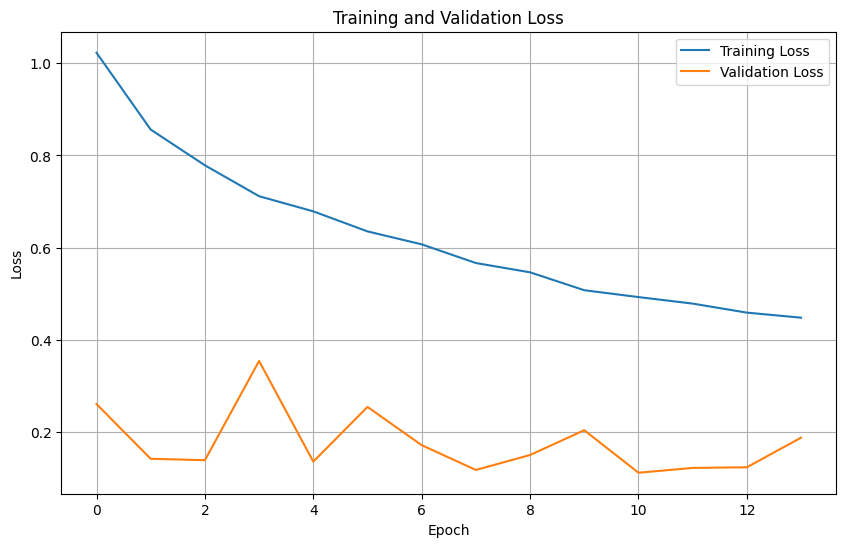

In [3]:
from src.config import DEFAULT_DATA_FOLDER
from src.models.lstm.utils import determine_labels

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

# Load the dataset
DATASET_PATH = f"{DEFAULT_DATA_FOLDER}/output/combined_posts_results.xlsx"
dataset = pd.read_excel(DATASET_PATH)

# Load pre-trained Word2Vec embeddings
word2vec_path = f'{DEFAULT_DATA_FOLDER}/word-embedding/SO_vectors_200.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Prepare the dataset
dataset['category'] = dataset.apply(determine_labels, axis=1)
dataset['clean_text'] = dataset['clean_text'].fillna('').astype(str)

label_encoder = LabelEncoder()
dataset['category'] = label_encoder.fit_transform(dataset['category'])
num_classes = len(label_encoder.classes_)

# Tokenize and pad sequences
max_num_words = dataset['clean_text'].str.len().max()
max_sequence_length = 250
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(dataset['clean_text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dataset['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
labels_categorical = to_categorical(dataset['category'], num_classes=num_classes)

# Define hyperparameters to tune
embedding_dim_options = [200]  # Set to match the dimensions of word2vec_model
lstm_units_options = [50, 100]
dropout_rates = [0.2, 0.3]
batch_sizes = [16, 32]
epochs = 20

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1

# For tracking best hyperparameters
best_config = None
best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

# To store the results
results = []

for embedding_dim in embedding_dim_options:
    for lstm_units in lstm_units_options:
        for dropout_rate in dropout_rates:
            for batch_size in batch_sizes:
                fold_no = 1
                fold_accuracies = []
                fold_precisions = []
                fold_recalls = []
                fold_f1_scores = []

                for train_index, test_index in kf.split(padded_sequences, dataset['category']):
                    print(f'Training on fold {fold_no} with params: embedding_dim={embedding_dim}, lstm_units={lstm_units}, dropout_rate={dropout_rate}, batch_size={batch_size}')

                    X_train, X_test = padded_sequences[train_index], padded_sequences[test_index]
                    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

                    # Build the LSTM model with pre-trained embeddings
                    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
                    for word, i in word_index.items():
                        if word in word2vec_model:
                            embedding_matrix[i] = word2vec_model[word]

                    model = Sequential()
                    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=False))
                    model.add(SpatialDropout1D(dropout_rate))
                    model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
                    model.add(Dense(num_classes, activation='softmax'))

                    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

                    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                                        callbacks=[early_stopping], verbose=2)

                    # Evaluate the model
                    y_pred = model.predict(X_test, verbose=2)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                    y_true = np.argmax(y_test, axis=1)

                    accuracy = np.mean(y_pred_classes == y_true)
                    precision = precision_score(y_true, y_pred_classes, average='weighted')
                    recall = recall_score(y_true, y_pred_classes, average='weighted')
                    f1 = f1_score(y_true, y_pred_classes, average='weighted')

                    print(f'Test Accuracy for fold {fold_no}: {accuracy}')
                    print(f'Test Precision for fold {fold_no}: {precision}')
                    print(f'Test Recall for fold {fold_no}: {recall}')
                    print(f'Test F1 Score for fold {fold_no}: {f1}')

                    fold_accuracies.append(accuracy)
                    fold_precisions.append(precision)
                    fold_recalls.append(recall)
                    fold_f1_scores.append(f1)

                    # Store the results
                    fold_results = pd.DataFrame({
                        'fold': fold_no,
                        'true': y_true,
                        'predicted': y_pred_classes
                    })
                    results.append(fold_results)

                    fold_no += 1

                # Calculate average metrics for current hyperparameters
                average_accuracy = np.mean(fold_accuracies)
                average_precision = np.mean(fold_precisions)
                average_recall = np.mean(fold_recalls)
                average_f1_score = np.mean(fold_f1_scores)

                print(f'Average Test Accuracy for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_accuracy}')
                print(f'Average Test Precision for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_precision}')
                print(f'Average Test Recall for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_recall}')
                print(f'Average Test F1 Score for config {embedding_dim}, {lstm_units}, {dropout_rate}, {batch_size}: {average_f1_score}')

                # Update best configuration based on F1 score
                if average_f1_score > best_metrics['f1']:
                    best_metrics = {
                        'accuracy': average_accuracy,
                        'precision': average_precision,
                        'recall': average_recall,
                        'f1': average_f1_score
                    }
                    best_config = (embedding_dim, lstm_units, dropout_rate, batch_size)

print(f'Best configuration: embedding_dim={best_config[0]}, lstm_units={best_config[1]}, dropout_rate={best_config[2]}, batch_size={best_config[3]}')
print(f'Best average metrics: {best_metrics}')

# Save the results to a CSV file
results_df = pd.concat(results, ignore_index=True)
results_df.to_csv(f"{DEFAULT_DATA_FOLDER}/validation_results.csv", index=False)

# Plot the training history of the best model (for demonstration, assuming the last trained model is the best)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
